<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>


<h2 align=left><font color="red"> Polynomial kernels: SRF Implementation I (Kernel approx) </font></h2>

In this notebook, we adapt the <a href="https://github.com/felixyu/SRF"> Matlab functions </a> (provided by Felix Yu in the paper <a href = "https://research.google.com/pubs/pub44290.html"> (Pennington et al, 2015) </a> ) as two Python classes: 
- <font color=red> **KernelApprox:**</font> approximates the kernel function by a kernel verifying Bochner theorem assumptions and yields an empirical sampling distribution p. 
- **SRFF:** (next notebook) Spherical Random Fourier Features object performing the low-dimensional embedding given the sampling distribution p.
<hr>

<div style="  
    padding: 10px;
    border: 5px solid gray;
    margin: 0; "> 
Schoberg's theorem characterizes positive-definite radial functions by their integral representation: 
$$ f(r) = \int_{\mathbb{R}_+} e^{-r^2 t^2}d\mu(t) $$ where $\mu$ is a finite non-negative Borel measure on $\mathbb{R}_+$  
</div>
Given that any finite sum of gaussians verifies the Bochner theorem, approximating the polynomial kernel by a sum of gaussians seems a good idea:
$$ \hat{K}(z) = \sum_{i=1}^{N} c_i e^{-\sigma_i ^2 z^2} $$ 
It's Fourier tranform is a probability distribution if $c$ is positive and is given by:
$$ p(w) = \sum_{i=1}^N c_i \left(\frac{1}{\sqrt{2}\sigma_i}\right)^d e^{-\frac{w^2}{4\sigma_i^2}} $$ 
However, for a good approximation, we let $c \in \mathbb{R}^N$ and clip the negative values of p. 
Let $\theta$ be the 2N-concatenated vector $(\sigma, c)$. 
The class solves the following minimization problem: 

$$ \min_{\theta}{\frac{1}{2} \int_{0}^{2} \left[K(z) - \hat{K}_{\theta}(z)\right]^2 dz} $$

Where: $\hat{K}_{\theta}(z)$ can be approximated on a grid:
$$ \hat{K}_{\theta}(z) = \int_{\mathbb{R}_+} w p(w) \left(\frac{w}{z}\right)^{d/2 -1} \mathcal{J}_{d/2 -1}(wz) dw $$ 

Avoiding overflows can be an absolute nightmare when computing theses quantities ... so as diving into the Matlab code ...

In [142]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from math import factorial
%matplotlib inline 
from matplotlib import pyplot as plt 
data = '../data/'

from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.optimize import check_grad, fmin_l_bfgs_b
from scipy import special

In [143]:
class KernelApprox(BaseEstimator):
    def __init__(self, dim, kernelfunc, eps = 1e-10, grid_size = 500, N=10, verbose = True):
        self.dim = dim
        self.eps = eps
        self.grid_size = grid_size
        self.kernelfunc = kernelfunc
        self.N = N
        self.fitted = False
        self.verbose = verbose

    @staticmethod
    def scaled_airy(order, x):
        #Airy function scaled by exponential prefactor:
        #If order == 0, 
        #  y = np.exp(2/3*z**(3/2)) * pi**(3/2) * z**(1/4) * AiryAi(z)
        #If order == 1,
        #  y = np.exp(2/3*z**(3/2)) * pi**(3/2) * z**(-1/4) * AiryAi'(z)
        #See http://dlmf.nist.gov/9.7.

        y = 0
        if order == 0: #AiryAi
            for k in range(7):
                y = y + (-3)**k*special.gamma(k+1/6)*special.gamma(k+5/6) *1/2**(2*k+2)/factorial(k)/x**(3*k/2)

        elif order == 1: #AiryAi'
            for k in range(7):
                y = y + (-3)**k*special.gamma(k-1/6)*special.gamma(k+7/6) *1/2**(2*k+2)/factorial(k)/x**(3*k/2)


        if x.any() < 0: #Should never happen!
            y1 = 0
            if order == 0: #AiryAi
                for k in range(7):
                    y1 = y1 + (3)**k*special.gamma(k+1/6)*special.gamma(k+5/6) *1/2**(2*k+2)/factorial(k)/x**(3*k/2)
                y1 = y1 * np.exp(2/3*x**(3/2))/np.pi**(3/2)/x**(1/4)
                y = y + np.sqrt(-1)*y1
            elif order == 1:
                for k in range(7):
                    y1 = y1 + (3)**k*special.gamma(k-1/6)*special.gamma(k+7/6) *1/2**(2*k+2)/factorial(k)/x**(3*k/2)

                y1 = -y1 * np.exp(-2/3*x**(3/2))*x**(1/4)/np.pi**(3/2)
                y = y + np.sqrt(-1)*y1
        y = np.real(y)
        return y
    
    @staticmethod
    def bessel_coeff_uk(k, x):
        #Precomputed Debeye polynomials
        if k ==0:
             uk = 1
        if k ==1:
             uk = x/8 - (5*x**3)/24
        if k ==2:
             uk = (9*x**2)/128 - (77*x**4)/192 + (385*x**6)/1152
        if k ==3:
             uk = (75*x**3)/1024 - (4563*x**5)/5120 + (17017*x**7)/9216 - (85085*x**9)/82944
        if k ==4:
             uk = (3675*x**4)/32768 - (96833*x**6)/40960 + (144001*x**8)/16384 - (7436429*x**10)/663552 + (37182145*x**12)/7962624
        if k ==5:
             uk = (59535*x**5)/262144 - (67608983*x**7)/9175040 + (250881631*x**9)/5898240 - (108313205*x**11)/1179648 + (5391411025*x**13)/63700992 - (5391411025*x**15)/191102976
        if k ==6:
             uk = (2401245*x**6)/4194304 - (388895895*x**8)/14680064 + (1441372804469*x**10)/6606028800 - (33010308331*x**12)/47185920 + (4445922195*x**14)/4194304 - (1169936192425*x**16)/1528823808 + (5849680962125*x**18)/27518828544
        if k ==7:
             uk = (57972915*x**7)/33554432 - (25388505925*x**9)/234881024 + (1007390378503*x**11)/838860800 - (1602251736839*x**13)/301989888 + (10559432785187*x**15)/905969664 - (36927006432745*x**17)/2717908992 + (1774793203908725*x**19)/220150628352 - (1267709431363375*x**21)/660451885056
        if k ==8:
             uk = (13043905875*x**8)/2147483648 - (928090660435*x**10)/1879048192 + (667955999804539*x**12)/93952409600 - (276439228010667*x**14)/6710886400 + (3542717254441859*x**16)/28991029248 - (39803268297948155*x**18)/195689447424 + (75358832548684685*x**20)/391378894848 - (512408152157076175*x**22)/5283615080448 + (2562040760785380875*x**24)/126806761930752
        if k ==9:
             uk = (418854310875*x**9)/17179869184 - (472414367256615*x**11)/188978561024 + (1359491937582325*x**13)/30064771072 - (3739063570455884033*x**15)/11274289152000 + (817138105244771959*x**17)/644245094400 - (17618708259302571707*x**19)/6262062317568 + (35348759075759093965*x**21)/9393093476352 - (3128960418491082175*x**23)/1043677052928 + (1330723971151926826475*x**25)/1014454095446016 - (6653619855759634132375*x**27)/27390260577042432
        if k ==10:
             uk = (30241281245175*x**10)/274877906944 - (20993386079260455*x**12)/1511828488192 + (45660648644355162105*x**14)/148159191842816 - (35892416277828185849*x**16)/12884901888000 + (1232816120293110459821*x**18)/92771293593600 - (5227733363217471800551*x**20)/139156940390400 + (19941766574064397067317*x**22)/300578991243264 - (16705838021516291703055*x**24)/225434243432448 + (91891691150784941691275*x**26)/1803473947459584 - (4318199286388002551911375*x**28)/219122084616339456 + (4318199286388002551911375*x**30)/1314732507698036736
        if k ==11:
             uk = (1212400457192925*x**11)/2199023255552 - (26416375998266454375*x**13)/314460325543936 + (241770821762631191867*x**15)/107752139522048 - (329641577686894230674187*x**17)/13469017440256000 + (527174389121818780771231*x**19)/3710851743744000 - (23186185730591085896097833*x**21)/46756731971174400 + (164293183874328160710877*x**23)/148434069749760 - (11694306169843138084657687*x**25)/7213895789838336 + (201734750392525792544487385*x**27)/129850124217090048 - (365967912305800454531456575*x**29)/389550372651270144 + (3424332034105686023665720375*x**31)/10517860061584293888 - (1556514560957130010757145625*x**33)/31553580184752881664
        if k ==12:
             uk = (213786613951685775*x**12)/70368744177664 - (1383228778609739182725*x**14)/2515682604351488 + (4288535808487871046652577*x**16)/246536895226445824 - (1247431715337149394208117*x**18)/5541538603991040 + (1440134927609056360249131941*x**20)/923589767331840000 - (12275126748382902959849354203*x**22)/1870269278846976000 + (40295057240679430076066704447*x**24)/2244323134616371200 - (1058890883945614567899138703*x**26)/32061759065948160 + (171527591207538652048777279465*x**28)/4155203974946881536 - (323782209780772997264458503055*x**30)/9349208943630483456 + (38826657063629086145255937175*x**32)/2077601987473440768 - (1480867953294613492234348347625*x**34)/252428641478023053312 + (7404339766473067461171741738125*x**36)/9087431093208829919232
        if k ==13:
             uk = (10278202593831046875*x**13)/562949953421312 - (311689729229640242227335*x**15)/80501843339247616 + (25668144329807404111206969*x**17)/179299560164687872 - (17485727773335283402112401979*x**19)/8068480207410954240 + (1172682485145099862891889874709*x**21)/66498463247892480000 - (18549286571206971359638512589*x**23)/211106232532992000 + (3692240508888356366982787102811*x**25)/12824703626379264000 - (14897903722108127256835851172369*x**27)/23084466527482675200 + (18618233657875371822100705069009*x**29)/18467573221986140160 - (328606042646275236446664121476415*x**31)/299174686196175470592 + (367634232582365988089137540027775*x**33)/448762029294263205888 - (179099209477310436044105950399825*x**35)/448762029294263205888 + (8323958765469022439849272062000125*x**37)/72699448745670639353856 - (3201522602103470169172796946923125*x**39)/218098346237011918061568
        if k ==14:
             uk = (1070401384414690453125*x**14)/9007199254740992 - (18797752383521406538249035*x**16)/644014746713980928 + (123552672971010529264790525*x**18)/99079191802150912 - (60197559206626892846461221113*x**20)/2758454771764428800 + (1533615778845746926778555049075167*x**22)/7447827883763957760000 - (1909654265469256217367321730519213*x**24)/1595963117949419520000 + (420670869682837226127426675930539*x**26)/91197892454252544000 - (2275295753169799866029447924232463*x**28)/184675732219861401600 + (103485029425656867671478423988690253*x**30)/4432217573276673638400 - (4678514217333130937255657203225879*x**32)/147740585775889121280 + (438926968126721480011081447330894535*x**34)/14360384937416422588416 - (662918789842359228359591343469410875*x**36)/32310866109186950823936 + (1177322813516754964196492125503858125*x**38)/129243464436747803295744 - (4198476740398490779853205916194986125*x**40)/1744786769896095344492544 + (2998911957427493414180861368710704375*x**42)/10468720619376572066955264
        if k ==15:
             uk = (60013837619516978071875*x**15)/72057594037927936 - (3735271835560741658500637055*x**17)/15924728282382073856 + (118145843799243877057467427205*x**19)/10304235947423694848 - (4682053290157804644291649610772557*x**21)/20390497672882657689600 + (4476579701403857364279102891783*x**23)/1801439850948198400 - (1517060956256085600229087638761327663*x**25)/91197892454252544000000 + (7325285829673636954246260387489676301*x**27)/98493723850592747520000 - (1527341067295812807125649376475592779*x**29)/6566248256706183168000 + (18546344338818795607290212453008613027*x**31)/35457740586213389107200 - (18242178522176433211173936393164309389*x**33)/21274644351728033464320 + (65544319685459694180664515606842619431*x**35)/63823933055184100392960 - (919693328928875517974470387276902815315*x**37)/1033947715493982426365952 + (187054812240653376693658577595543666125*x**39)/344649238497994142121984 - (2825480904467831144445100711243097375*x**41)/12764786611036820078592 + (4537353791587797535655643250859295719375*x**43)/83749764955012576535642112 - (4537353791587797535655643250859295719375*x**45)/753747884595113188820779008
        if k ==16:
             uk = (57673297952355815927071875*x**16)/9223372036854775808 - (255005467589750245013902496625*x**18)/127397826259056590848 + (23930632228676872808287094850927*x**20)/215596321361480384512 - (411326657717984844291245101099269569*x**22)/163123981383061261516800 + (12139335575858921085347526474466207309*x**24)/391497555319347027640320 - (19184188463249985491959692568453667557*x**26)/81064793292668928000000 + (66886935239112343759822339412549592082043*x**28)/55156485356331938611200000 - (10352066634614181764059489715007707655223*x**30)/2363849372414225940480000 + (1609057486347529247953695407110092411199*x**32)/140079962809731907584000 - (18949942802726836829409263606971205617559*x**34)/850985774069121338572800 + (59074304522438219672139306944094150384209*x**36)/1838129271989302091317248 - (31659227230675746511992457214201335968895*x**38)/919064635994651045658624 + (298380340782844687194470219764567108053325*x**40)/11028775631935812547903488 - (125147594895406727667181525777666404273125*x**42)/8271581723951859410927616 + (849525181693753993883643210633357171800375*x**44)/148888471031133469396697088 - (7845084705655301939148607180735722298799375*x**46)/6029983076760905510566232064 + (39225423528276509695743035903678611493996875*x**48)/289439187684523464507179139072
        if k ==17:
             uk = (3694483615889146090857721875*x**17)/73786976294838206464 - (5601202382478651012510097287895875*x**19)/309831513462025628942336 + (25307936122315048864599612652365261*x**21)/22422017421593959989248 - (17075739714414991994043276803439819669*x**23)/591596305815902175100928 + (639250722250629496365483268167565271593*x**25)/1597949205385089908736000 - (6202733385292850084270145070389220684392643*x**27)/1797692856058226147328000000 + (4918554203860156635144716898340926135544589*x**29)/245139934917030838272000000 - (109487110251520541349783293821947174450442753*x**31)/1323755648551966526668800000 + (22656976680462433461046473301644789924750967*x**33)/90771815900706276114432000 - (17023703028998683474035793235643067182905467*x**35)/30257271966902092038144000 + (352014074661025026479632974329618842445974511*x**37)/367625854397860418263449600 - (6046767369418617392447022239134638130160647*x**39)/4901678058638138910179328 + (434324663126461865364496896478471302338035*x**41)/363087263602825104457728 - (227437475147602591711240197307248667449645125*x**43)/264690615166459501149683712 + (4754087392220751898398489247314331285540440325*x**45)/10719969914241609796562190336 - (1667275152429410778583358653001802852281228375*x**47)/10719969914241609796562190336 + (76858294861304993097838904549667871361337476875*x**49)/2315513501476187716057433112576 - (22605380841560292087599677808725844518040434375*x**51)/6946540504428563148172299337728
        if k ==18:
             uk = (502860269940467106811189921875*x**18)/1180591620717411303424 - (32848477905191480676470504898494775*x**20)/190665546745861925502976 + (7216070211653983528525765701391767079653*x**22)/599833810062481617632362496 - (1244871457408461970370166238367252101607*x**24)/3619177400285519188852736 + (67512932186883166194556881593301716464061*x**26)/12654466434564752408576000 - (2698766759858833014205911295589437107851741*x**28)/52296519448966578831360000 + (39732393413258582818456597433543988061348917673*x**30)/117667168760174802370560000000 - (146957279777702083489469692961702969742402769*x**32)/93386641873154605056000000 + (196172231632052896021939551786629194331093001899*x**34)/36308726360282510445772800000 - (18261434948825344307602068729927718533955986373*x**36)/1307114148970170376047820800 + (14416334392120207468368228108578563189046136643*x**38)/522845659588068150419128320 - (2731124460448440343256369615269965213481857679*x**40)/65355707448508518802391040 + (22868999656866719261134680839956677441101178409*x**42)/470561093629261335377215488 - (10120723781510555707788922845057965284862967265*x**44)/235280546814630667688607744 + (9764679006095184354177598214026976455096819542925*x**46)/343039037255731513489990090752 - (3509140234776489527398109461648354044083449543375*x**48)/257279277941798635117492568064 + (2044604580045901059668365698711801118797401693875*x**50)/457385383007642017986653454336 - (49826780450967195819487209825993506486664725449375*x**52)/55572324035428505185378394701824 + (249133902254835979097436049129967532433323627246875*x**54)/3000905497913139280010433313898496
        if k ==19:
             uk = (36232405765710498380237842265625*x**19)/9444732965739290427392 - (5270618082084864640591779010940423175*x**21)/3050648747933790808047616 + (643617691230342300867772202166782802324525*x**23)/4798670480499852941058899968 - (511290603091990756321621785602479678715718017*x**25)/119966762012496323526472499200 + (9578510926265808749239543652362821145078653469*x**27)/130290386410278690798698496000 - (3608793655049366427755026382191879580906402267*x**29)/4555607916443310867087360000 + (778605359192630424174485689370678541153366154099*x**31)/134476764297342631280640000000 - (187973203756033464466274463861125534417385919868989*x**33)/6212826510537229565165568000000 + (18892625343549330867979679263691816799239745614837*x**35)/161372117156811157536768000000 - (897888445598605915923390318015931467120927078392341*x**37)/2614228297940340752095641600000 + (16222238070489694130918937921555356858923228707359*x**39)/20913826383522726016765132800 - (70239668257654763841328806708670410338848690183*x**41)/51639077490179570411765760 + (6991065680795630961804716828763946745922759601591*x**43)/3764488749034090683017723904 - (66667297710177390946655195253136110176945908415243*x**45)/33880398741306816147159515136 + (488393019248226745499796510949450606738795530834905*x**47)/304923588671761345324435636224 - (8088398159551059878168644656424684012396121108257975*x**49)/8232936894137556323759762178048 + (43398697174771671575635378868549090707872913819769875*x**51)/98795242729650675885117146136576 - (13349386123251183201469531253100521966852501723899375*x**53)/98795242729650675885117146136576 + (613716454814562950908623963426762019396249423359951875*x**55)/24007243983305114240083466511187968 - (161504330214358671291743148270200531420065637726303125*x**57)/72021731949915342720250399533563904
        if k ==20:
             uk = (11021897833929133607268351617203125*x**20)/302231454903657293676544 - (443863585329019676901014600158486627725*x**22)/24405189983470326464380928 + (7051504650692012922107270586229951846285125*x**24)/4516395746352802768055435264 - (281455295925390008139045560174186364411534291*x**26)/5132267893582730418244812800 + (92819048753175303652301382783593067554729561856361*x**28)/88722541529943377286281727836160 - (12674074492013646204309038268611734847410602546809*x**30)/1015249764235937850379468800000 + (131810321642212959067823751018561574030743411653989*x**32)/1301602261840945962024960000000 - (146418779187950135225508434919692120653775229217054181*x**34)/248513060421489182606622720000000 + (1824336367202196000530904722626314573557902316050369351*x**36)/715717614013888845907073433600000 - (3906663644300258072745811444749701215638380977439083*x**38)/464751697411616133705891840000 + (179753625149125126857292240802977667122589767348030603*x**40)/8365530553409090406706053120000 - (21595789303723522142722550461795057852700907459698657*x**42)/501931833204545424402363187200 + (9079828598096525946757702627510256710073940544191563*x**44)/133848488854545446507296849920 - (22830571636776305811972242610676904910054857771278061*x**46)/271043189930454529177276121088 + (1199349512131949785092521372248630847266863258754124905*x**48)/14636332256244544575572910538752 - (50196165852977381848005361305078288352521092865332843*x**50)/813129569791363587531828363264 + (111549656209419888821395674550399025985589438923447496675*x**52)/3161447767348821628323748676370432 - (105189027214710231484783695637837900781660279240767956125*x**54)/7113257476534848663728434521833472 + (182894486402114387773498357808723553155777102174932206875*x**56)/42679544859209091982370607131000832 - (442037351796699683325500996815538854496719650456891653125*x**58)/576173855599322741762003196268511232 + (442037351796699683325500996815538854496719650456891653125*x**60)/6914086267191872901144038355222134784
        if k ==21:
             uk = (882276678992136837800861860405640625*x**21)/2417851639229258349412352 - (3601863375850721941134465726404739628869375*x**23)/17962219827834160277784363008 + (11636012637930893116357496749137014206091373255*x**25)/614229821503981176455539195904 - (104392943374522986327161123219037126149263496233*x**27)/142623023569035876885961113600 + (318882827614495782877146446223016905753960001860199*x**29)/20753810884197281236557129318400 - (1088234168339950246779000834589819245239646315685409887*x**31)/5388008594935832628721562419200000 + (6778092592066390402910468646387625117318852478375083*x**33)/3748614514101924370631884800000 - (1259954758557860262541614757440759697441640955358141041991*x**35)/108241244094693066201995673600000000 + (103948063410295300109566013588489288279056607856996909191*x**37)/1859006789646464534823567360000000 - (5097681450828076156452601417693508837778855430567550639*x**39)/24786757195286193797647564800000 + (54131922623521119144353295846786658324673623820924249*x**41)/91802804426985902954250240000 - (53554837271745590089748337619111480761419974252975404401*x**43)/40154546656363633952189054976000 + (346461683842702502080560162932309920326032941097720383733*x**45)/144556367962909082227880597913600 - (33063635010120972399234777612458335698852059269923207817*x**47)/9637091197527272148525373194240 + (457269943742018458843771837212180633436501622187169963231*x**49)/117090658049956356604583284310016 - (1233349808938159584983440018590335385963922198574167509427*x**51)/351271974149869069813749852930048 + (6917264816013883432252595158356080640736850880957442585535*x**53)/2810175793198952558509998823440384 - (299803193949148812529649487428299273970786604853599377125325*x**55)/227624239249115157239309904698671104 + (532055746636321797087804484520373031253282935480154886480875*x**57)/1024309076621018207576894571144019968 - (16193637736972925421725874572655878501311880188802637533125*x**59)/113812119624557578619654952349335552 + (1337162989185016542059640515367005034852576942632097250703125*x**61)/55312690137534983209152306841777078272 - (955116420846440387185457510976432167751840673308640893359375*x**63)/497814211237814848882370761575993704448
        if k ==22:
             uk = (148302689041496455735799416353639046875*x**22)/38685626227668133590597632 - (332073446135546784224083686241998203006956875*x**24)/143697758622673282222274904064 + (82693125029477684924414098677282792398976910258065*x**26)/345702996008828935078035236847616 - (5585436433495548583153190526622481251117545627293*x**28)/551821443918015174569682272256 + (3477975368433094977787233513447821349320389475554763627*x**30)/14942743836622042490321133109248000 - (9945430488741205467473056975346043783432579353299612743*x**32)/2964830126313897319508161331200000 + (48733082165485087839813906498850723040121004025263922351*x**34)/1477853786039542663877914263552000 - (1820614930483987715332914309003780860256853497313678258511689*x**36)/7793369574817900766543688499200000000 + (3088728341815904916175956479933000312873293448749599621431177*x**38)/2493878263941728245293980319744000000 - (5003315868003919000134550065164480303827913595359354920511*x**40)/991470287811447751905902592000000 + (134112497310507682599931168369714925532958635573865160407393*x**42)/8328350417616161116009581772800000 - (7276898585248876923939680022059269689182972124391109499983*x**44)/178464651806060595343062466560000 + (955527463467585833042403049867886649064622120741114150784077*x**46)/11564509437032726578230447833088000 - (93389385578941122112910632847954580705633153743195587194977*x**48)/693870566221963594693826869985280 + (81579349026649916265853483855559562986377791119753384783027*x**50)/462580377481309063129217913323520 - (520633711000711955991906527488128574368216764019251143321357*x**52)/2810175793198952558509998823440384 + (62645916944334201901559967175697152521821099379989653710983317*x**54)/404665314220649168425439830575415296 - (20532817151688513679944050045562468464219483272549311742502905*x**56)/202332657110324584212719915287707648 + (1672957394323402512429007240647035474716660439381236592705589875*x**58)/32777890451872582642460626276608638976 - (467252291432876308261007267953586199590743739511431348622501125*x**60)/24583417838904436981845469707456479232 + (485393221446707713376888500542257952234422236065605889656093125*x**62)/98333671355617747927381878829825916928 - (3178054378724445744320891322022980394977474656367171708563984375*x**64)/3982513689902518791058966092607949635584 + (1444570172147475338327677873646809270444306661985078049347265625*x**66)/23895082139415112746353796555647697813504
        if k ==23:
             uk = (13057084578653492298477992092005176953125*x**23)/309485009821345068724781056 - (63881841061417460560126117044175857304644748425*x**25)/2299164137962772515556398465024 + (7766306081078717102552658788250080000424812510523015*x**27)/2474505655642143956348041695330304 - (147603846418781123497889146283372464079417235402042369*x**29)/1018914093499706334966840698077184 + (33417952196478088203151885428753580717861699927440711989*x**31)/9195534668690487686351466528768000 - (1577399784357289865813270322474400475345934888249906234479*x**33)/27586604006071463059054399586304000 + (20178746713532090646701331350405706974306188457660170520743*x**35)/32841195245323170308398094745600000 - (4755251866546922263545054499633841071688710349393325704950224433*x**37)/997551305576691298117592127897600000000 + (778782353044251754377015353369914847185676925697129708247315789*x**39)/28069625481595209687291553382400000000 - (398231759233031087573950632984346712117120800538303725392763*x**41)/3198817718700308796272541696000000 + (29263361929733875772983354882323555601563016206864853870145293*x**43)/66626803340929288928076654182400000 - (2222665408717572286527821325962617352818612268394229356871386431*x**45)/1798923690205090801058069662924800000 + (143821733770330388990402148726558299076185911915108961158434563*x**47)/51397819720145451458801990369280000 - (1424377065090533189747864509426425487277571135349043597113191949*x**49)/277548226488785437877530747994112000 + (254496731723314102009663829791441844730487973887175715883138507*x**51)/33305787178654252545303689759293440 - (184415376387096941953156894893207349478290967008369401715451053*x**53)/19983472307192551527182213855576064 + (145667467785608001202143207257917528177866106016227681820477712167*x**55)/16186612568825966737017593223016611840 - (68209307548588717219996066619296639328974086572510362528327405441*x**57)/9711967541295580042210555933809967104 + (13994212724840723785179369406340877734881477812680981106144178015*x**59)/3237322513765193347403518644603322368 - (1613382568684986823317540920622197800647927899700130570975856778125*x**61)/786669370844941983419055030638607335424 + (5121861816684832095900688933166392225557549096995241231076824734375*x**63)/7080024337604477850771495275747466018816 - (1264540559307330111789532303846710258748418896742567010994001984375*x**65)/7080024337604477850771495275747466018816 + (5264302621339829627933723707143702343353142337606021427431305390625*x**67)/191160657115320901970830372445181582508032 - (1144413613334745571289939936335587465946335290783917701615501171875*x**69)/573481971345962705912491117335544747524096
        if k ==24:
             uk = (9614366611415188162445961510413145296484375*x**24)/19807040628566084398385987584 - (376446109033272332065136012354514176092773017775*x**26)/1081959594335422360261834571776 + (265662732561310733128838422112356738891269018733254375*x**28)/6216939829051336882064501449424896 - (1485194077025985600703178275664372145672887225927198592673*x**30)/692861583579800307777451674692485120 + (1667465687322450726531991712454791896830351120646120031562429*x**32)/28529594617991777379071539546161152000 - (220709387077761065839773023610937950778181894692206200661557*x**34)/220692832048571704472435196690432000 + (1161867287597955672621146405592783311268771361450741705215894899*x**36)/99311774421857267012595838510694400000 - (140407677060382566581340823226704136203549599960351155480899721*x**38)/1418739634597960957322797693009920000 + (96732190459707245530314445401874578661513592331682751098556408838469*x**40)/153696793748112437043303083409408000000000 - (2084283857893795728757556431272675009894339299079790324507316494457*x**42)/673671011558285032494997281177600000000 + (49740600573130715887766197733835056154364702518396425497894507769*x**44)/4145667763435600199969214038016000000 - (76587575255677638683521855144680233604116263900421855908945151309*x**46)/2055912788805818058352079614771200000 + (461747375807618028852687814942488783827193771331808256400526094883*x**48)/4934190693133963340044991075450880000 - (26252585194995166985647375289214953748135467414800759389703469683*x**50)/137060852587054537223471974318080000 + (4272000556519249365888077402473036359613532749064952766322887131959*x**52)/13322314871461701018121475903717376000 - (9485641831123649298426990826278048216604445143512898547722601992963*x**54)/21582150091767955649356790964022149120 + (56649413097136698258246007199183604021904037500067428712561583148559*x**56)/115104800489429096796569551808118128640 - (34788538415518232180028669059113593162757910360340299301727047145591*x**58)/77695740330364640337684447470479736832 + (152796051299184506372142132217465401802798019666093043153248365807133*x**60)/466174441982187842026106684822878420992 - (132945080203286968535094966090039081336074063701445653902862713731905*x**62)/699261662973281763039160027234317631488 + (19339646949385204336135748268274681675081827804773618916185177170034375*x**64)/226560778803343291224687848823918912602112 - (1619896902764524903453332206778828215257311530510742739955957593328125*x**66)/56640194700835822806171962205979728150528 + (28231812702346969527073139755829052296001262817839174349613351015625*x**68)/4195569977839690578234960163405905788928 - (4549501878450947544106027222908494412123061314982386431002263358671875*x**70)/4587855770767701647299928938684357980192768 + (22747509392254737720530136114542472060615306574911932155011316793359375*x**72)/330325615495274518605594883585273774573879296
        if k ==25:
             uk = (923363769360314671121310143460078474274359375*x**25)/158456325028528675187087900672 - (313718822263146600653563948312712364044784337455525*x**27)/69245414037467031056757412593664 + (1578353575980774463221335426000146878099442239008551275*x**29)/2617658875390036581921895347126272 - (2149017802495908277373843891739538946845209902884821098219*x**31)/65596362942466301328042762101063680 + (1506693574371792599184092138050129436061478476570003173741993*x**33)/1557200615938547848917884700312207360 - (70460773857631569242328281394349308782579427372149984515374365461*x**35)/3927351553433249354256135677993287680000 + (2348845808293897121545739108238566083496893147341204539075121829*x**37)/10318106433439716053256710494617600000 - (21579838239746481999353095507697653227173144953133253141610508303*x**39)/10318106433439716053256710494617600000 + (659015229271827668111328398387897405444917845746504784947773728433487*x**41)/45539790740181462827645358047232000000000 - (515093804301993260985774931898619296700648995773689828827854751271304357*x**43)/6639701489918457280270693203286425600000000 + (31916737268071571910775109157262100766857253281149621135932595454713067*x**45)/97008625664393044679279608489574400000000 - (1003836233779334522033312946222089355663054826854858776655471255353263*x**47)/895464236902089643193350232211456000000 + (612523744723408283880475635042679785372716832082722166698324094964747*x**49)/197367627725358533601799643018035200000 - (833213730438616410106528354982453257047370228781146891952535149651467*x**51)/118420576635215120161079785810821120000 + (155471967442635036391453420743479529304066514009270892729921394968349*x**53)/11842057663521512016107978581082112000 - (174459677921770752620550302107747100637669056452013754900552956639392751*x**55)/8632860036707182259742716385608859648000 + (212601235497642911300959670205020728284723640938813522857309746612055471*x**57)/8287545635238894969353007730184505262080 - (8217364122169231843408202653667966656013128259299959010439554841354147*x**59)/306946134638477591457518804821648343040 + (85116311756759180911975871557625209479110626684578589313016527252836475*x**61)/3729395535857502736208853478583027367936 - (1583950654864744963336809562811601985507753519002735502506157771802955875*x**63)/100693679468152573877639043921741738934272 + (1737440404114174277725194251743193432812573747534086514871356890904067875*x**65)/201387358936305147755278087843483477868544 - (6663100715859830968116791144203454965643660511930135717213624181788128125*x**67)/1812486230426746329797502790591351300816896 + (3188657436131490167395412947892054602134149336705613932191657270295421875*x**69)/2718729345640119494696254185887026951225344 - (2149587370563475126281649092281742682969166036558825643150111369011796875*x**71)/8156188036920358484088762557661080853676032 + (98291988083932721690410718150938021773918739710194458841803899864105859375*x**73)/2642604923962196148844759068682190196591034368 - (19658397616786544338082143630187604354783747942038891768360779972821171875*x**75)/7927814771886588446534277206046570589773103104
        if k ==26:
             uk = (184743781854321419968194437164589547045200671875*x**26)/2535301200456458802993406410752 - (33933260100144421439148977814291289768859322014623125*x**28)/553963312299736248454059300749312 + (1218804849708592824313094830409160054755199131046508241445*x**30)/138394486629316716679001075743719424 - (284612378715933892342485100576243995653281797200517740589117*x**32)/550846476386425089413129281743093760 + (1888404232187900063928729744516017766488346244664294903299853425*x**34)/114609965333077121680356313942978461696 - (1586394174235529077535305530198564170700150653683219376017237268616673*x**36)/4807078301402297209609510069863784120320000 + (102394378270724568558492244625789852900689741760452196994679174248793*x**38)/22621544947775516280515341505241337036800 - (18574585233549891825390146659981819729438336193812658718851409894481*x**40)/412724257337588642130268419784704000000 + (418322321334084606738072821645752773930193478533287258397632857231482279883*x**42)/1239410944784778692317196064613466112000000000 - (637219808617932801536255664380413017724367362668167363996470287370207243*x**44)/324283345050962504530925186973696000000000 + (95323611872499163407924838721569705647980797983431404276871645263253347621*x**46)/10506780379651185146801976057947750400000000 - (3627055513703314218697032203251210023766962070062762570613452874015406663*x**48)/107455708428250757183202027865374720000000 + (978092783924874641151422894946109699895261770058890526456064902651795353*x**50)/9551618526955622860729069143588864000000 - (1210298773191349813197854360416054814123356430691124820867128065429396971*x**52)/4736823065408604806443191432432844800000 + (8994278025223758924080517047060862885313880826772814801619196798078364939*x**54)/17052563035470977303195489156758241280000 - (6935805075312757907901036394951796369751163843227567362287006905187397197*x**56)/7673653365961939786437970120541208576000 + (853370692513943967735941941484581931313745144276097620317458198411415195143*x**58)/663003650819111597548240618414760420966400 - (1512833106951070632196307286694423678400773644201556122016704089328303290911*x**60)/994505476228667396322360927622140631449600 + (197067886612238771533667970396589880554110694970406989473236041289957413863*x**62)/132600730163822319509648123682952084193280 - (960106118328539390146261388403644377353603253013590293729763442988389950925*x**64)/805549435745220591021112351373933911474176 + (2500623904999177839094274543853278392917623293113014539154462100114432199625*x**66)/3222197742980882364084449405495735645896704 - (24084647329180462860570023098633100307581034456317453618114126134945206875*x**68)/59670328573720043779341655657328437886976 + (14237581584180635068532237274153664892187933348231009250522599815786238996875*x**70)/86999339060483823830280133948384862439211008 - (29262467964326174128661163972977558012987241922335486245912167758738567015625*x**72)/587245538658265810854390904151597821464674304 + (50343573069936639120083020939436882596545759654223987948293968722746203359375*x**74)/4697964309266126486835127233212782571717394432 - (92020959244177814046562514332908175984742724116684052367696811052775905546875*x**76)/63422518175092707572274217648372564718184824832 + (35392676632376082325600967051118529224901047737186173987575696558759963671875*x**78)/380535109050556245433645305890235388309108948992
        if k ==27:
             uk = (19220195675140328470024376814641927320369210640625*x**27)/20282409603651670423947251286016 - (11618011506443975947412600466565128276447229807284999375*x**29)/13528367205635664172772816607772672 + (3386674925635360943751669835907108902786531101519696513919635*x**31)/25464585539794275868936197936844374016 - (952316764897307491508342519469846909625054926757462221223667895*x**33)/113355730279151107630615650347624955904 + (134148989830719394371122120871798349684910873907176150251417104633*x**35)/465083917293646290876808230493245931520 - (43502954423812894126709563383506391967449746638318848184286424296372737*x**37)/6992113892948795941250196465256413265920000 + (30619398105537168815357378741777464146130716192722633979054637765040899*x**39)/332957804426133140059533165012210155520000 - (53659773650883421256254900824162696134119827196135287271771016404610703*x**41)/54404870004270120924760321080426496000000 + (3168763244368123974280616789890000188505775130530496844861963851850544216009*x**43)/396611502331129181541502740676309155840000000 - (22455840354619781995515820127053935018976510113296902313783801825959634474745961*x**45)/446187940122520329234190583260847800320000000000 + (11765250754342762054143817797245162755260219791592925115803114419661064502649*x**47)/46696801687338600652453226924212224000000000 - (5395851173334097149085705801615611675977493941518697335072667532556560282444047*x**49)/5295417311344197313988195933205666201600000000 + (4967442466115962665963480846987776013443698729733638162472473146762261799391*x**51)/1473678287016010384226770667867996160000000 - (542611340104170730860433829899801198435069798626501397637892703598273506331*x**53)/58947131480640415369070826714719846400000 + (14247977024610315889125328944908400217447704523656685229764098882708278894491*x**55)/682102521418839092127819566270329651200000 - (145700452740184287501624433197927767912250097556510683799197297163375709723833*x**57)/3683353615661731097490225657859780116480000 + (20511113943131115904047268115852759281084893420796012186742942517902026966961*x**59)/327409210281042764221353391809758232576000 - (264073067932790047559624459559927191330352537285442978352117692748992103991391*x**61)/3182417523931735668231554968390850020638720 + (525434213771504849726524148481183254437103410690206919135971405025799676709705*x**63)/5728351543077124202816798943103530037149696 - (482485783524253010620579030454611868908672124355772557434349063753958553326205*x**65)/5728351543077124202816798943103530037149696 + (1643637297674350120338749984620685788378252574323772968077455009766140548227575*x**67)/25777581943847058912675595243965885167173632 - (3042360193128042487276472595418078139986669110964601800595051814401371515328625*x**69)/77332745831541176738026785731897655501520896 + (1504509932079087620295266988766272291926381482623340115268511775633339786749375*x**71)/77332745831541176738026785731897655501520896 - (141374413068374034405153792452319834991141768121810341982307482819467865833890625*x**73)/18791857237064505947340508932851130286869577728 + (247016105147191970460110349158635174299625092157595687967341339001362495350484375*x**75)/112751143422387035684043053597106781721217466368 - (5659076963656925937563948174067555799614708079894694372566423702761725619921875*x**77)/12527904824709670631560339288567420191246385152 + (178924137447314046588843128830224612643564756730570983976790176383155120346796875*x**79)/3044280872404449963469162447121883106472871591936 - (894620687236570232944215644151123063217823783652854919883950881915775601733984375*x**81)/246586750664760447041002158216872531624302598946816
        if k ==28:
             uk = (8305870273899927660260534266327404306302408883984375*x**28)/649037107316853453566312041152512 - (1349463284458456304232957001188549157914464129473593706125*x**30)/108226937645085313382182532862181376 + (24510435234027110651673117298780346868283946112112619258772905235*x**32)/11815567690464544003186395842695789543424 - (38154026130873918064894214971776883829530989729193944408829841773845*x**34)/271146906827729449452432635631518894522368 + (96813225714243228848504305476912302286015627168171012947359876581631193*x**36)/18662887433159438360304560673232972740034560 - (13145636678023423952094111075043544796759695654895928742888454528313669*x**38)/109387737347465607614225295812011443093504 + (355896995005908189984192298193614300071931461980538358951731412006669477547*x**40)/186456370478634558433338572406837687091200000 - (4398399891330955101450820008016240235810789682405784632810485920955206336609*x**42)/199774682655679884035719899007326093312000000 + (2978786441195345902132046197767026009848785095244615103134372992067039733617599*x**44)/15511916535617496878067662746451202539520000000 - (51165742930715875990753369562443301199497068721971532374895449525265190268342681*x**46)/39225313417364424548060710616338268160000000000 + (30187160408574861775300086936783116324445986910844207687891789716812458010053693*x**48)/4279125100076119041606622976327811072000000000 - (7343736805962335481875291372107418825379891644724240204941567081845645731655537*x**50)/237729172226451057867034609795989504000000000 + (5127035945661991318180752674913266575614240498356367785322626666904662528201633179*x**52)/46214551080822085649351528144340359577600000000 - (35009185706730048663685199229620479577706809468710798121252494272980453606779781*x**54)/106104836665152747664327488086495723520000000 + (48634929451148944774838095164634162197030317108696157113634156089680921639536709*x**56)/59418708532485538692023393328437605171200000 - (50155444685730187702797951354208201138420607943190220048573333708096691958169837*x**58)/29466828925293848779921805262878240931840000 + (4209249517537655170422704568748231520718302649635709923421813290308732704968736173*x**60)/1414407788414104741436246652618155564728320000 - (309736167727209284239625713308432819851347325393966199765102744804979940734745597*x**62)/70720389420705237071812332630907778236416000 + (2484356584912688393829861971854238358000723044360464996164571508256052057384369657*x**64)/458268123446169936225343915448282402971975680 - (773708524798919640916360863632410913018718716805562971445273661295268725229562095*x**66)/137480437033850980867603174634484720891592704 + (33092575462325778823958338978874920140701066329505704137124522836691996156635325*x**68)/6789157384387702758893983932567146710695936 - (2161571470914349270301980820004202774277659465207198151817390369726196874430509975*x**70)/618661966652329413904214285855181244012167168 + (22809679289972840816753090108101660321529399214202018001888410553695556727356262125*x**72)/11135915399741929450275857145393262392219009024 - (16126353437804021351282406144474686347642053300115512301380049854195001467745323125*x**74)/16703873099612894175413785718089893588328513536 + (1287407436564911303610956234607942151210315509909699170906896055128022924419769234375*x**76)/3608036589516385141889377715107417015078958923776 - (269424840670644110748794131384446673355939059097067591060915346325251666378680546875*x**78)/2706027442137288856417033286330562761309219192832 + (106705814996531963240304373078281589482909859465982548747802260840836909660861671875*x**80)/5412054884274577712834066572661125522618438385664 - (4870493945453335662194898809887544180770476242962872754832205391325865530960157734375*x**82)/1972694005318083576328017265734980252994420791574528 + (3478924246752382615853499149919674414836054459259194824880146708089903950685826953125*x**84)/23672328063817002915936207188819763035933049498894336
        if k ==29:
             uk = (930543879996581550627119856251646089350914705657421875*x**29)/5192296858534827628530496329220096 - (20104674159678211114535974166078927263042484091369941041105125*x**31)/107361122143924630875125072599283924992 + (8930686704534156691085901249315695791807089595353736951481944125*x**33)/267499345706426517180448375136925515776 - (13269679961145366477748812690870434639579366270924879038226551257885747*x**35)/5470094120350715849822988823174989872103424 + (16901451588840293688291578121096195126353015637981953207085342612818720023*x**37)/176449117549871053588334028183293560451235840 - (10755079549153951765608206449228261247676714512027051237710454490230243939*x**39)/4524336347432591117649590466238296421826560 + (35865031001072419465486807628869181171724328456522535477155234937320017039*x**41)/886304791342291424519731776146584371200000 - (2395987619287955611652122389786286365836040781551474764977095945676447761431*x**43)/4786045873248373692406551591191555604480000 + (26178587496876137917380149605221352538527484598877754125240247900132109932109128279*x**45)/5584289952822298876104358588722432914227200000000 - (4779045515680704508972440919721541817651825370466658896367464085007462971115909581237*x**47)/139607248820557471902608964718060822855680000000000 + (375328603622517869352743578985456834755982741593321518750390873887885033599531669609*x**49)/1882815044033492378306914109584236871680000000000 - (96716816197647061019034835463722601206423663399206837686425678134702672298801319011*x**51)/102699002401826856998558951431867465728000000000 + (21463164787342640509255070810767260837249503045175856582980519016879865157697766021*x**53)/5868514422961534685631940081820998041600000000 - (61674609950829127764809266551547286332658985356011125549807789339915867982338271188629*x**55)/5228846350858727404898058612902509255065600000000 + (378287707349826982933618233573467310259080873512089181772498264652150801218017505379*x**57)/11883741706497107738404678665687521034240000000 - (103091179343156566784289859663675693415142779851827081386786937243262736543135401543*x**59)/1426049004779652928608561439882502524108800000 + (62760690128676169298994968040967922533530790382032877612948260510213343737661747321*x**61)/452610492292513517259598928837809780713062400 - (183379944420011355174315933727088294805040419155833771449542324305686644162583009919*x**63)/814698886126524331067278071908057605283512320 + (629970171755112356170266870574568597109036873603572873629318121996250566618007375151*x**65)/2036747215316310827668195179770144013208780800 - (3951248040801819098515102965988756252664721934806172057261807732059214033604300441791*x**67)/10998434962708078469408253970758777671327416320 + (4639184807760358916132384538819104802184459929768458654249662140378956691939407188735*x**69)/13198121955249694163289904764910533205592899584 - (1267302573671322435742412211402300631662345358174557779874373375103493994863544544975*x**71)/4399373985083231387763301588303511068530966528 + (17466485261409159632000899740994302345507905181773950963561940573347764273312840918875*x**73)/89087323197935435602206857163146099137752072192 - (87778068340998553343099717319342965477917218428009310959930972146549758578176958681125*x**75)/801785908781418920419861714468314892239768649728 + (17563818537120018606892550469306498885008271254344484210618038320366508498499831066875*x**77)/356349292791741742408827428652584396551008288768 - (1510615869518228228044360067247253663909761190650090222295008353252851003806762247296875*x**79)/86592878148393243405345065162578008361895014170624 + (1820713869532094154882940908063494911758072184534543182731699646820234030825223529265625*x**81)/389667951667769595324052793231601037628527563767808 - (3121353329831388923350032254657930442016324277394521917747585233924155655165216502109375*x**83)/3507011565009926357916475139084409338656748073910272 + (20342661640459882107941750929240304173312344845072215819004169860884904361240304525703125*x**85)/189378624510536023327489657510558104287464395991154688 - (3507355455251703811714094987800052443674542214667623417069684458773259372627638711328125*x**87)/568135873531608069982468972531674312862393187973464064
        if k ==30:
             uk = (215948216417873358515533614640798669135368939359565703125*x**30)/83076749736557242056487941267521536 - (2495842812524883878245316674854105000805688243868419294426774625*x**32)/858888977151397047001000580794271399936 + (57469643912016650848385518270593236938811163087959597767429584989596875*x**34)/103755506217843066071814872161109573655068672 - (1882255478011682768207196415511523915699554502662537740126181907753820257*x**36)/43760752962805726798583910585399918976827392 + (108963664406794005207198555687118289274033207458577167856856515288207006434475*x**38)/60039753064969457167657125323168688836207181824 - (113246529493683393579183310079300188147787760548663138206644481977020919193539*x**40)/2352654900664947381177787042443914139349811200 + (40785310968772003213275097012600834826488056804670585229026166803736212897554595147*x**42)/46555421015081362600614285897592070180595302400000 - (29813384905720014202961580666800899011163779158729667782335995346199522983333*x**44)/2571257856201812484320980097831849164800000 + (799055789048547421401384045014887718944784251205831073052814148749710074074475824401*x**46)/6872972249627444770589979801504532817510400000000 - (11088348409495616704743196394071677209476585585771375261371343623774637630317765754537*x**48)/12183905351612288456954964193576217267404800000000 + (9627514480944089303943264758538369833027022165951124271385835088986131156696920658781943*x**50)/1692209076612817841243745026885585731584000000000000 - (118733314651507895123551591160225400739444831334268343244640136864182914048657952694637*x**52)/4107960096073074279942358057274698629120000000000 + (10732444140388542710647711543227976502190425001392960486933233475294131469477038984745477*x**54)/88731938075178404446754934037133490388992000000000 - (1958382568436297526813173411339232641586560238776197180226013686041599231377513457023989*x**56)/4647863422985535471020496544802230448947200000000 + (20610569414420531238679412335824188885751610696802268733637681606447528048842702727746553*x**58)/16732308322747927695673787561288029616209920000000 - (371624689944343931001056529619939198457017770707727884611622583663143867490637280104253*x**60)/122232771838255965309305266275643073495040000000 + (4479834831949331704683369176565025872310220279997723262250835922758165371169664048712293*x**62)/704060765788354360181598333747704103331430400000 - (368939660660191714118892375583323043681547576435028667644923808445351300019150534828591*x**64)/32587955445060973242691122876322304211340492800 + (1117463542774473056625799105422672217979807601312116983234413176682541074003870206364989*x**66)/65175910890121946485382245752644608422680985600 - (888761242744927431966581049975428394793636660844227195475420918053868505230718025439*x**68)/40232043759334534867519904785583091618938880 + (25515413293359036725565270037522676740072879833003110292025586960681600550523274805971239*x**70)/1055849756419975533063192381192842656447431966720 - (21244785926358408955181646176375535375451301338992781099059214725848321033571682986383365*x**72)/950264780777977979756873143073558390802688770048 + (11013725163807497010848861215554030646752037225228200996505451398078023066895558192004075*x**74)/633509853851985319837915428715705593868459180032 - (72246840741718421867628057875736759451725542621783786908434811185169525756757092154930875*x**76)/6414287270251351363358893715746519137918149197824 + (924270724713312352865872096974052780727194110861605214654586380629325899859773295704766875*x**78)/153942894486032432720613449177916459310035580747776 - (199131853616930253423525173742888993718628725015571729942938505415424234027780753025269375*x**80)/76971447243016216360306724588958229655017790373888 + (10953775049071505075078069091178089060705950408402489030853039981805386612705596155289140625*x**82)/12469374453368627050369689383411233204112882040569856 - (19039510471373779306925923559847234894074700506756750769939956048705467573026550365663734375*x**84)/84168277560238232589995403338025824127761953773846528 + (1552744780128744180551276422084498361899361350746697166993931000075058740405654458161328125*x**86)/37408123360105881151109068150233699612338646121709568 - (21973581927151924380388805098567328559621006974892660707941573134214469969512156526470703125*x**88)/4545086988252864559859751780253394502899145503787712512 + (21973581927151924380388805098567328559621006974892660707941573134214469969512156526470703125*x**90)/81811565788551562077475532044561101052184619068178825216
        if k ==31:
             uk = (25920752041642153775364534841239091866216381398611096171875*x**31)/664613997892457936451903530140172288 - (639623519099220536607540538109625786677031934366670429611478334375*x**33)/13742223634422352752016009292708342398976 + (341571695327370850713041756493690472480966853305674752326884743495861625*x**35)/36088871727945414285848651186472895184371712 - (578425546819180545689584452171790928571612730438015354009312410793233360596577*x**37)/737981337964755776731319068112184233625217138688 + (31423887688567313187863914842857437594876782253037036831055053305292787974779*x**39)/891128060333498436625708724648143804619030528 - (64044717049402577115706309867749837514838277674881642239958420354063014152481531*x**41)/64213639641678563815676069864351538862253670400 + (220593092405513106248961951752901489901171131547226175138001474652112532094248363559*x**43)/11392385377808145201091495843175471291251556352000 - (269666267355392954371054019017899288149546634561797302386256734147654837462185495649767*x**45)/985879503848781796248302524890185015589076992000000 + (17897487939881989480030430408585171853557707183777763465816377061535700773410346762263*x**47)/6109308666335506462746648712448473615564800000000 - (73611112934744130625669877157518337754247694673099640532677525955230762535752139592073867*x**49)/3002114278637267875793703177297179934688542720000000 + (145669023384397370139455509008221353289561502037651353218032992933911124492209503947658591591*x**51)/887684532760323873292433105531981543768064000000000000 - (9334808751889839720017412238102869718766774243759533740034042195597365629479446135380298211*x**53)/10443347444239104391675683594493900514918400000000000 + (14260406273962258701317172436272111871829461371396082655949793130403451139695775452664328571*x**55)/3549277523007136177870197361485339615559680000000000 - (352920522772898417969041203401545673075801027728405948120914549623729679650080217936919300311*x**57)/23425231651847098773943302585803241462693888000000000 + (35700553376350063221049625433414645777259514669217849607747101952293343209644404224471983*x**59)/751169846139076439760888330473087749324800000000 - (556143881377343368289644670101239946216321961288804722691663662791892279442591549188328891*x**61)/4380822542683093796685500743319047754062233600000 + (2924953206775987175842562521266218063554930858829190836572396308052269361723152017251774271*x**63)/10138475027352302786615016005966939087972597760000 - (1134727715057145909293772280641684257422515869898039138317670631672199519094131592702144523*x**65)/2027695005470460557323003201193387817594519552000 + (96795845146362604110237114482351629208159522977318241844780448493526130050482362783577797*x**67)/104281457424195114376611593204231373476289576960 - (2060207914448805790309544185114277898332979826655316083789429840612023253408633937117787043*x**69)/1564221861362926715649173898063470602144343654400 + (1498958054444347684895661274141607245072110149520779354286489407392471504476418940991886229*x**71)/938533116817756029389504338838082361286606192640 - (25100492778250369960313914032431003962317113315602656261264021985780349059198579530300932393*x**73)/15204236492447647676109970289176934252843020320768 + (66061373478520702974678625392829279469555066646790077690424049910803860887403091364146904355*x**75)/45612709477342943028329910867530802758529060962304 - (5430059589015227282003604661554397720862281132014174200644624142624631628644681002146975075*x**77)/5068078830815882558703323429725644750947673440256 + (815606857828127509698302875897559136241799871674133509163053190931990207373633450905228707125*x**79)/1231543155888259461764907593423331674480284645982208 - (3742909407087477171263671228043553705644715100278451626058421993434877101247077710429489693125*x**81)/11083888402994335155884168340809985070322561813839872 + (1546434312860829423272749293125915054639424065374861005122233145535598801066245193299309728125*x**83)/11083888402994335155884168340809985070322561813839872 - (122614027057203727725192329877337821959986783734448355457001410305054988131597941615427120009375*x**85)/2693384881927623442879852906816826372088382520763088896 + (91202812321602738055305009545038516884545584402161020160054835451559479969128155264428824578125*x**87)/8080154645782870328639558720450479116265147562289266688 - (16143126078758799297282067581502923579826188049797722252952366104488283478165228687055683203125*x**89)/8080154645782870328639558720450479116265147562289266688 + (147157078166136437575463827745105399363781883710856148761084715279834305385822912257774298828125*x**91)/654492526308412496619804256356488808417476952545430601728 - (23735012607441360899268359313726677316739013501750991735658825045134565384810147138350693359375*x**93)/1963477578925237489859412769069466425252430857636291805184
        if k ==32:
             uk = (102879464853277708334421838784877955617012817771087440706171875*x**32)/170141183460469231731687303715884105728 - (84515655256042452964103260161216675813485994174906395944398979865625*x**34)/109937789075378822016128074341666739191808 + (2210368251915771134533881892430081034796158589251800420322244685784171236625*x**36)/13280704795883912457192303636622025427848790016 - (86600993650418583138318225523540702248091082480648173627168491915778677878263125*x**38)/5903850703718046213850552544897473869001737109504 + (580438725939177178319659777887503581765124774319888563085056498504470818657473265029*x**40)/826539098520526469939077356285646341660243195330560 - (133670272870426818235403829091930027384560756264638611801935426964927890855329073641*x**42)/6323936372987378560605891570089241206572292505600 + (2041628349245808379666911357716590947146166883917988538346567708332787474553823677797*x**44)/4673799129357187774806767525405321555385253888000 - (389709088330228215440588164217379967053765209595870675760381705753147810979965674985139*x**46)/59301022787896649398394136835499850561748992000000 + (24635973017206340865801353963881609298091762785916683906955917923357769208170364351492553*x**48)/328436433902196827437259834781229941572763648000000 - (451278256113176658157643245631016500850564234283175652478321166662862033902476502084335359*x**50)/673875258953371015890842464039771029110784000000000 + (3330772408349738283245492305894914584006638138329524180299561526455261836285126411156731848769381*x**52)/695944673684093916661267554737073530314162176000000000000 - (1781621244292053214572947357578831124077987528480867035989361714733857470973501023557418874405371*x**54)/63913286358743318877055183598302671151300608000000000000 + (8476030955460564703739629110380501391303300609592524043378496188020214854509976836228153353400027*x**56)/63161365342758103360854534379499110314226483200000000000 - (14455169659720758401398621614701799703244406115238712393054702069500456572513645981101661981259*x**58)/26771693316396684313078060098060847385935872000000000 + (294220953651592381482195464002233706974783521232222075733197934088971950158526181469901846398467*x**60)/160630159898380105878468360588365084315615232000000000 - (2567519387996044857524973533387147540133648402082109148338418838346443484632247193363208352423*x**62)/486758060298121532965055638146560861562470400000000 + (588717342193445085452754968104092023833792546928161642383537756508592732951033922699606771676189*x**64)/45420368122538316484035271706731887114117237964800000 - (2212541789266825808961285503132814964113672104771856003203070998904525531922121839739776959737*x**66)/81107800218818422292920128047735512703780782080000 + (11845247770049645585495782184712754835110833140355985645945986177781300834819042380908019107*x**68)/240319408055758288275318897919216333937128243200 - (4789349116259842190464263928536634864647014640060572441296796477870012052504838525968594562027*x**70)/62568874454517068625966955922538824085773746176000 + (138056612211579533562052658138579069063945911140517619235734800142189403799600852462993083322619*x**72)/1351487688217568682320886247926838600252712917401600 - (7904294475204964669341808091255550481831951249074278563170016600465775431298218517413198069679*x**74)/67574384410878434116044312396341930012635645870080 + (83624533981058445646129241760934562790525893879283080118768190791351001481441328834110077767911*x**76)/729803351637487088453278573880492844136464975396864 - (104626195419215175852830101740914189737630118178380253264567643976975974537437134733349537770025*x**78)/1094705027456230632679917860820739266204697463095296 + (590428276506377763659696137426446317313079063899185275296095898719252974768713677263641685784525*x**80)/8757640219649845061439342886565914129637579704762368 - (3532781785925504963206862458166128531842475377645181032506778779122326360287265012346322235117875*x**82)/88671107223954681247073346726479880562580494510718976 + (10358160251550277704615864252468730027156691964565659306056447519938078895427372467966113424588125*x**84)/532026643343728087482440080358879283375482967064313856 - (2055212067264542595697606229966386306669410791079832249881445871294245762809920335794352953971875*x**86)/266013321671864043741220040179439641687741483532156928 + (627307291200434023157857151457036706638501001458012834252453679356378210616761589249913747797578125*x**88)/258564948665051850516465879054415331720484721993256534016 - (337416999866371645786664415137726671582960132270126277522056448287400980095683155602018407542109375*x**90)/581771134496366663662048227872434496371090624484827201536 + (115364672098115469161911284629242578268955007974198078697818307259103647117151578726698376045703125*x**92)/1163542268992733327324096455744868992742181248969654403072 - (169548689059996617447833597921675146744393469048408034364505250827414254369852805068094342943359375*x**94)/15707820631401899918875302152555731402019446861090334441472 + (847743445299983087239167989608375733721967345242040171822526254137071271849264025340471714716796875*x**96)/1507950780614582392212029006645350214593866898664672106381312
        if k ==33:
             uk = (13171689060760555082210068753518465529753913790389225363138671875*x**33)/1361129467683753853853498429727072845824 - (16007043198900159912954000262234499150821381581457864510369649663499375*x**35)/1223655391447694714614295088324638488395776 + (319742661427492904709211202437976652561380615261133983315729857944281529291375*x**37)/106245638367071299657538429092976203422790320128 - (65766125599527540422416202299964268638706958655694047304374158931727042539888588625*x**39)/233421667492455645347611928717268718919870333321216 + (5572276522987968386484941909444126643256774484524018988018402683585154472254553640377*x**41)/388959575774365397618389344134421807840114444861440 - (36661751325972018833217197892932478121120614633329241306115645664232183007183568024268455*x**43)/80047880694364398829864527022864008053495552752484352 + (659844591020062446554552394647946901272650200516565550580895369740158900452697161228791493*x**45)/65620139776174916358287016056690714637608964587520000 - (2254398608638686197545838820354565003918278600105850724178378441713948788343520321312197987*x**47)/14021397388071563324420302576215964666155761664000000 + (66663653896432064986723908418719708197463577500000085302073552144867159127367222895356371581*x**49)/34157389125828470053475022817247913923567419392000000 - (237539496852592944032360695837081421809803228360523547851874066233109279230814126917591231651709*x**51)/12809020922185676270053133556467967721337782272000000000 + (499123172824920405415999502356521626084644586205221325907232157169535396385823039662571290142789*x**53)/3534957072681111957644533611362913169849712640000000000 - (31396045821540070748248549550614633117822332524350498716123867210939147863440177672051910928180401939*x**55)/35791440360896258571150902815049495844728340480000000000000 + (44708107541347588028184380275567626642973550391690252461753452823085918959690657594550343480167208469*x**57)/9911475792248194681241788471859860387770925056000000000000 - (22871649443938199486542269379897612181677213575779727863472895210311526846498354983715917216460997*x**59)/1177834318746071857545072902181801590941286400000000000 + (329987481588611905657968733570951056584846013627515357311511383379084715615704079870495994344683*x**61)/4672877378861966716464534126206984270999715840000000 - (12864628195152684412022800854226374052223800241362352139334247918777854519114714971280951631969387*x**63)/58878254973660780627453129990208001814596419584000000 + (16678972825037480510578012211321571718883365865097430907944742053346151327046366349964918088140223*x**65)/28838328966690994593038267750305960072455389184000000 - (68268034963334394674955175642036397946763659722771239593056430942870641182039062722228199531960637*x**67)/51908992140043790267468881950550728130419700531200000 + (10030338272904494772879658390737208147167922487380499361571280790319711013399609714595618005858773*x**69)/3893174410503284270060166146291304609781477539840000 - (3391342880210446846636362621986943173376861127975734874397941788000979647427822677905138570234707*x**71)/778634882100656854012033229258260921956295507968000 + (68735264570934261952841940539349935930355619328161814539414863824310465444073625673485925460053863*x**73)/10811901505740549458567089983414708802021703339212800 - (259695117588467369403571892310531612482782976152193773248272045120432627043816456142590950883362123*x**75)/32435704517221648375701269950244126406065110017638400 + (3129440506971357233809266931369510382534959892714219952917895428407546131760429158349803203085881*x**77)/360396716858018315285569666113823626734056777973760 - (141570847772828917820124429172681204102017177931399573772600605642709984968401042377938481609818517*x**79)/17515280439299690122878685773131828259275159409524736 + (12153860696071278004026291810623872927685644797630040938365970828383310008680738288529955422308015975*x**81)/1891650287444366533270898063498237452001717216228671488 - (2730793538649693346194994247038822027052836290739157741335314872289793920379876178642876753441514875*x**83)/630550095814788844423632687832745817333905738742890496 + (10434225124090867257831457138712168976096315701573823929282204178257739937317217579685215749143918875*x**85)/4256213146749824699859520642871034267003863736514510848 - (14684910868858498618728321960784696943055096348291819998088825624288295708134010355375987493570051875*x**87)/12768639440249474099578561928613102801011591209543532544 + (100903176871158732443606651504993505688013674068653273651502524635155857275069940643075381919878990625*x**89)/229835509924490533792414114715035850418208641771783585792 - (2473515016749269770875187666685384820726553151940655411539704307024579919092543107207761327930409609375*x**91)/18616676303883733237185543291917903883874899983514470449152 + (285431961114074312369885264496875079969525002215562215581558622663979203866585093683746501863002734375*x**93)/9308338151941866618592771645958951941937449991757235224576 - (582501831210312986226536162074362467506130860678352629057530605198687087526164453851746114342578125*x**95)/114917754962245266896207057357517925209104320885891792896 + (6446410706750131391984081226580010754368584086689521874572854141709117365396173501494015013049466796875*x**97)/12063606244916659137696232053162801716750935189317376851050496 - (2930186684886423359992764193900004888349356403040691761169479155322326075180078864315461369567939453125*x**99)/108572456204249932239266088478465215450758416703856391659454464
        if k ==34:
             uk = (3478100717279654809649470507914375986062665823826896038537029296875*x**34)/21778071482940061661655974875633165533184 - (2242995390564074395769834867110596898289516526218666319604876586081574375*x**36)/9789243131581557716914360706597107907166208 + (28895253430930409153080571645858957932817748532385786425604457502197420164878453125*x**38)/516778785017434801534266919108236253448452117102592 - (10365213800813796902570072008718317280132711168741979101064155687324680565539365013575*x**40)/1867373339939645162780895429738149751358962666569728 + (2284778452680810082660615538923117283070201739919206753917659275534558980953293260501237327*x**42)/7635625194829073220777882070977579224694682517304770560 - (28712890293350807007751749155743920466622550181639795206066422346045379189050169149161637*x**44)/2831047946750288199111035438474412309584281264455680 + (237491454972783287858739193426156754763555506008740982938074651171770380804931305509365269233*x**46)/1005767033713918175999973116300120162615468343951360000 - (2321572288425667758009930523257436120537320441114660614232011656102220479105604406746554307*x**48)/579640542741331613028667053868449448399931965440000 + (5538893099580232519535991935905239231909985615519059698611771634663282034709109820778636249397*x**50)/107340841248394743153456861827490638592579993600000000 - (693742500413094426435105876860057157040944621772401786336249618218752562866967102979426555493069289*x**52)/1332138175907310332085525889872668643019129356288000000000 + (660859162968730169110183577204507892539790014819498457183494448368619529378798303354101180601013974651*x**54)/156782416087552677545450354731167924909174455009280000000000 - (886612203460448820828014619383319482329143079374824520377657055068144407424702250095901253130948452261*x**56)/31814613654130007618800802502266218528647413760000000000000 + (18517678050160723089068181389302046776652403894351621648048110690508203282071696210313471232497666342267*x**58)/121269821458095558452840706008638291803314847744000000000000 - (1402237952283651325803616707733952371924539740581328090983272612241634449577259041437082663101251222739*x**60)/1998953100957619095376495153988543271483211776000000000000 + (198224776853964977282527887493309865951074330638435890575605880811795812322104677810026048229261115609*x**62)/72689203671186148922781641963219755326662246400000000000 - (21284628299086214825615874044955171907828699748965909129063858446172110394998120860208507403166307541*x**64)/2355130198946431225098125199608320072583856783360000000 + (1741986949332642454778835837986211414880404671791727676341930853044469438043360751373498056494903324973*x**66)/67827749729657219282826005748719618090415075360768000000 - (107427177387205728639814084894644937370308755993170682623823434260347704595529466117831165212403191*x**68)/1708938012840947827735601051869982819108467507200000 + (2318999131818483897699783360693156593374063487848110411897572085183917640987728681555182782459923637047*x**70)/17441421359054713529869544335385044651821019378483200000 - (9752158689957853222051140466388187341128106451991807107906605471131161783296460214275499861001829431*x**72)/40044079650890923920618851790424847414895197552640000 + (37165237711209521521300360315717369181758317953226586547237688552342216195737688035260854485793167077*x**74)/96105791162138217409485244297019633795748474126336000 - (138137610252338525361480794460898458944187443235892021260895080233100559652794287154346283334236665231*x**76)/259485636137773187005610159601953011248520880141107200 + (197612260974721476302995193259718710996857732074821805478038870863352957836300186210141587404577487401*x**78)/311382763365327824406732191522343613498225056169328640 - (50884240148946597806485512035844378285091645013211746045087961159320863101831982607518503407391157211*x**80)/77845690841331956101683047880585903374556264042332160 + (17540922543916725563623032898786599673672528055527451099161228969635720709918339405886043937232235585107*x**82)/30266404599109864532334369015971799232027475459658743808 - (19975626607355719705132009751571055982212878249055730540270067190689009631525767042520981638601347425075*x**84)/45399606898664796798501553523957698848041213189488115712 + (954917320316131239133459868508439973883698337781828937061729420993737785990281477431790589715665091875*x**86)/3362933844345540503592707668441311025780830606628749312 - (15755204044023285548526976416783139928523966679263943530599774600533155215162014492609430237158842678125*x**88)/102149115521995792796628495428904822408092729676348260352 + (2302625136706932278479113011691989657418252441363612449398035344017996871596375541404705772068863297666875*x**90)/33096313429126636866107632518965162460222044415136836354048 - (423386061524358176144821533237803992503520430125794090775648407844594191628027688181815896425808032821875*x**92)/16548156714563318433053816259482581230111022207568418177024 + (2225716976267508299737124101489851133893447128032194873864750383884287807899726509655546026604281542109375*x**94)/297866820862139731794968692670686462141998399736231527186432 - (372376360898951558969004484876697106956747139322943788032468719386183213104569444744393229900772739453125*x**96)/223400115646604798846226519503014846606498799802173645389824 + (5720200803281729534396456110939707570408899409906976164860730633325963142338211095922155884505433716796875*x**98)/21446411102074060689237745872289425274223884781008669957423104 - (23674150301871368894725539028195699494929790122726965015192689887511201291809929176350338589287210017578125*x**100)/868579649633999457914128707827721723606067333630851133275635712 + (6962985382903343792566335008292852792626408859625577945644908790444470968179390934220687820378591181640625*x**102)/5211477897803996747484772246966330341636404001785106799653814272
        if k ==35:
             uk = (473121071856241044249746545376581259132695771063995772556422756640625*x**35)/174224571863520493293247799005065324265472 - (23921594627420235831642207753935321617915443221769945486084928458352374766875*x**37)/5795231933896282168413301538305487881042395136 + (5211682830294553819878122730279709161919367703104682126593316201244793918361295216875*x**39)/4885908512892110850869432689750597305330820016242688 - (2603935665997188561895506198884633415307062630685178266341232000536770221006047824168475*x**41)/23229933313213386372803773325438261868567760639885312 + (7015344623146557352180740261551754425798502297457023234801920817975921295456869250065651915*x**43)/1096882380929006184037441882641980421132610739327991808 - (1028804618315041442307826145774329919772858526956212276773193339009706222783053918555522911999*x**45)/4483918520482867326293213480210542878378581164661145600 + (442651134529522357605166178408644524708739692136844401035078330136681888986966064793725718503*x**47)/78277823412450364952378860049983750495417915146240000 - (37977783771727470958972619259740700103212145175012150938723290440115552434034371485036522607736881*x**49)/373911739036973038540790005507600801616475792592601088000 + (1252316981120409501363144459596896741246594537764377162565087484335042819818803684088676401062691*x**51)/903335910765711604720000603431349789714179686400000000 - (1405030602198103300967786807287513780723719295010106776949877317371934632784422143706524070748567941*x**53)/94729825842297623614970729946500881281360309780480000000 + (10383609196487992304246941617616617217710782935370841547966216787369475953329324113014389195147656707823323*x**55)/81526856365527392323634184460207320952770716604825600000000000 - (614715726461030562953728022599641849960449556736718849336442788365173813921380194245376069272303838881938663*x**57)/687430593614654047699282324590505516909457225809920000000000000 + (37085936346848543631045768731633444287081448921656899953758815428395648807539157266234995392367672745767*x**59)/7119354104420701005605773986521111838578442240000000000000 - (20740362218853307254083831871827656649906647529583540509411534905961673907015041804984720852642965369293*x**61)/814119081117284867935154389988061259658617159680000000000 + (22105674354852634281322785321923659771680190134544521373055096139526905798859303220411728390216532022269*x**63)/209344906573016108897611128854072895340787269632000000000 - (1017244520427661562876289899562175011520702614587983388551059912961939580512994040347950845763262208088229*x**65)/2721483785449209415668944675102947639430234505216000000000 + (440631148585233170470787460625051334639561278093843328689979265427502099715374326305814617622630339698277*x**67)/387587141312326967330434318564112103373800430632960000000 - (694209432822178304737213554695902100705110710629607374591406059297862458706746556167913701918616512776463*x**69)/232552284787396180398260591138467262024280258379776000000 + (105294545817529063383270969077759998706196937355947104765392721848531929356475525013398517798994855518551*x**71)/15503485652493078693217372742564484134952017225318400000 - (3371125616874538291647286389707194255465454327785622779618244825353300979138834723259505631316676785969839*x**73)/251156467570387874830121438429544642986222679050158080000 + (1330774374818257192564185034832401603216390992628262630094397230439642542549060467101439449231760961932689*x**75)/57663474697282930445691146578211780277449084475801600000 - (8852419935022590809545986156248478373517963234783074969044752950427391146337482873454649247707613495269*x**77)/256282109765701913091960651458719023455329264336896000 + (560303092646304944977359792098297263678451780169336542688464113585187171507005644049065979386168937314169*x**79)/12455310534613112976269287660893744539929002246773145600 - (1141214075140157089275383703327822041775446112800568606000809855961777453897611899056855268013049988144489*x**81)/22419558962303603357284717789608740171872204044191662080 + (1342848816436149422234516867653744087805504215883041506388843645340650026627351501193426235764781491440361*x**83)/26903470754764324028741661347530488206246644853029994496 - (30687454335020318800252182096202763006082816068561298372019286912016633225414512329438594337992339241026591*x**85)/726393710378636748776024856383323181568659411031809851392 + (66886456661777194281054234108181780238612980918104774502048462228042474500352494109375362601544102888671075*x**87)/2179181131135910246328074569149969544705978233095429554176 - (13800506184087273394831825329906677220420663457494513081436599677330077691479312649910523862155626201288125*x**89)/726393710378636748776024856383323181568659411031809851392 + (2626100340858999825159754442401464442055813187633768023461893725951786156548219643967819124695538149315273125*x**91)/264770507433013094928861060151721299681776355321094690832384 - (1140690092623375747333184227383160827586195230550227617007380075391452663035947637204106138581424165258415625*x**93)/264770507433013094928861060151721299681776355321094690832384 + (14986845209046435750278368568472846918594259387858308858600501923668308042924752729581773027933391491565625*x**95)/9806315090111596108476335561174862951176902048929432993792 - (3082938378334328734316278554420868676095065045755179895707002150232012918824777326466512071336378026001328125*x**97)/7148803700691353563079248624096475091407961593669556652474368 + (143743177116137110451109267189196507149621576698368530127381767309802382759462889168163104286479117134809765625*x**99)/1544141599349332369625117702804838619744119704232624236934463488 - (22287838042357633161369446960584726693611983813154668403032803245548010179429354921112275236470054470236328125*x**101)/1544141599349332369625117702804838619744119704232624236934463488 + (59665821746098752958500924686061455580015697518131577416231223425318671726329200915337073932824147835478515625*x**103)/41691823182431973979878177975730642733091232014280854397230514176 - (8523688820871250422642989240865922225716528216875939630890174775045524532332742987905296276117735405068359375*x**105)/125075469547295921939634533927191928199273696042842563191691542528
        if k ==36:
             uk = (265000369247479011562552481693705125254213264659289187717436346247265625*x**36)/5575186299632655785383929568162090376495104 - (3543230830890101904728017131351726845004588024972003812258941340086918109765625*x**38)/46361855471170257347306412306443903048339161088 + (60394375613855732728036346468650823060165728064953657242084717283659300837872408043216375*x**40)/2892457839632129623714704152332353604755845449615671296 - (5810743941725756860445062925566217715367541655625086207674340492033019458080590674721309425*x**42)/2505628669094188709452765619378306314651032940743491584 + (31812780584297212170301499079475412606252277242482179113059566818900334209888688876150553478205*x**44)/227517711339580777503376151660610873004143010598468190208 - (9253422368748207153907360927369542845415100597431486068139346541504862691780767353189763810907*x**46)/1745701402009028409608660821180870696762775712458342400 + (29686790159115289211070369811228078264190588080571059188337879099004680710219822004044664584721*x**48)/215013075907270361300773473576529528633538357546188800 - (220037267171557613670754447869344983357836480471182745935272939662546357149494951144183096568872727*x**50)/83930805619971501355957352526958653561498494409113600000 + (771840969087708349724842259848939728995833186407543450173160404055075488731731334322251551893559915631963*x**52)/20395185765653074829497636664050952815444134141414604800000000 - (131501569489827533240423942342430073868215678586431838027080951187594239771012285768661390152574680796219*x**54)/306924635729044300512505165026662855351607403688755200000000 + (3952726952925039046527881987106401552069219983415945651517149416330210886892246961354606751634121983189144953*x**56)/1014556434771007548916336517727024438523368917748940800000000000 - (9056993136881083598834806563911405360621067087729629529706647477283232641177556304981266389357960918397564089*x**58)/312405432795634377307371328687853263482886107326054400000000000 + (496824625714719714174934285724457204248620953877026954216161120978063208450404270068479371492767233124729574579*x**60)/2772829285168352461308029544566744942155793852006400000000000000 - (84196860862769988396053002544710790853280915407024183915566612167405006089361265294202893662064103008766727*x**62)/90457675679698318659461598887562362184290795520000000000000 + (481089110700500076714541374844816038023867756354344401862120496190602406248637414680991367879853357276709941*x**64)/117233147680889020982662232158280821390840870993920000000000 - (112312982677782740785448405548472002180735054401180841202073072800469009364982725688005320667210931895507371*x**66)/7257290094531225108450519133607860371813958680576000000000 + (388899276545253605349807946277746944096209061673516338273575313377294435578165270185624706176309900304858639*x**68)/7741109434166640115680553742515051063268222592614400000000 - (1312420468105603378011307079246926961745018890723801865871502358653017621812032125114101958184484617001210169*x**70)/9302091391495847215930423645538690480971210335191040000000 + (1646297264555221979290329090241327116387885827680755034463075527745466194388304337926229107503965265426446287*x**72)/4783932715626435711049932160562755104499479600955392000000 - (16654973209942453988870194284966134426941387641064720979806098395523520528842790665882575093168985807023459*x**74)/22780631979173503385952057907441690973807045718835200000 + (10004860093732199582413361314265026879863737398083051856718280303676010468967876667113931885374946476531796609*x**76)/7380924761252215097048466762011107875513482812902604800000 - (607689513491367707975513631970177234085597470719144203745399306508414615182933200694826758837760257803062109*x**78)/276784678546958066139317503575416545331755605483847680000 + (343999748682010255393526516454516657631957768958787789314659818995314907586401260922723927741052608963298131*x**80)/110713871418783226455727001430166618132702242193539072000 - (3442645866841740681165761605547422570542061608961338939705974453674731575348193173433960060597020595248737841*x**82)/896782358492144134291388711584349606874888161767666483200 + (53377640463468593278069074762813743874150721029010913000297224665620029628333198729896752135674193919655421437*x**84)/12913665962286875533795997446814634338998389529454397358080 - (277450568588349319036527951161920783918796409671410474553655409712042467416748812683576242956513831198039485*x**86)/71742588679371530743311096926747968549991052941413318656 + (109167362458940356707952853801128865197241076208455665465301491778638500667838249465340233781035236507470769975*x**88)/34866898098174563941249193106399512715295651729526872866816 - (342176431086319159138544342962541380043304706078437714220359835007742957166160784782353251869535428033403986375*x**90)/156901041441785537735621368978797807218830432782870927900672 + (2441763321892024725260603776053204063488445880235629156360935976286417492484985477944832668189016284901194198125*x**92)/1882812497301426452827456427745573686625965193394451134808064 - (1380389059717900633247724212987045379270783447990703032659792968639997683371709333634182189641062049389781889375*x**94)/2118164059464104759430888481213770397454210842568757526659072 + (3468992233759508323616173779412419959168846176326929491522432921315299406245704073429476301323609649727348821875*x**96)/12708984356784628556585330887282622384725265055412545159954432 - (594269425338247279219743078738598326720695390625296273958027707251422156732571529110164668896448057288039890625*x**98)/6354492178392314278292665443641311192362632527706272579977216 + (1261327723662763561702612279187542464736794714581860777032122102008887544147860578044462211733672790649424548515625*x**100)/49412531179178635828003766489754835831811830535443975581902831616 - (197801548348473722230598076660020802989421149260008360052247648322349259053474312372658843355311510869378792578125*x**102)/37059398384383976871002824867316126873858872901582981686427123712 + (6610557060826723230891323706458399553831756947268250861047438312545856844740290801235249064378846676337853515625*x**104)/8235421863196439304667294414959139305301971755907329263650471936 - (77335428671764855084639841382376512353926060511715400271066555733988044081854977129264753113216213330185224609375*x**106)/1000603756378367375517076271417535425594189568342740505533532340224 + (386677143358824275423199206911882561769630302558577001355332778669940220409274885646323765566081066650926123046875*x**108)/108065205688863676555844237313093825964172473381015974597621492744192
        if k ==37:
             uk = (38167215343778801422076815539074448985937905064036542739086980787883203125*x**37)/44601490397061246283071436545296723011960832 - (2155918201410855036865031718510173312414601809375731765517953262700704800775390625*x**39)/1483579375077448235113805193806204897546853154816 + (9698200862577835381466341054487977696401291767818798489676602893587623204229856968277850125*x**41)/23139662717057036989717633218658828838046763596925370368 - (124306038034390010615376617821794970435554647508007515336713060906465024791784480733331805900625*x**43)/2530390175941707750816769420793338988819349030981427265536 + (31011265329498145073731013559970134209752569048756662962617543275192070360342908094833073565848171*x**45)/9922707926810103586598856678875674203277462913842870747136 - (340774123248232836705107344025996401018231592788997186243288227893209502474984493021122259292315043*x**47)/2726018661211566919395290296394415989911390910396393062400 + (3185648422869113905891627970346605424922125035252831677658581242298157880645985896187304033150944133*x**49)/927136383312149797928935218061995327467817397739166105600 - (746556451477823128103595864070577435246291431485992610897432805588106329111374472966462151415143666404817*x**51)/10841174300320478887146299311202195363231637525836385484800000 + (108734184153963415387961966915969818202658950079240629436064460608705410767738169421091948035111489912097*x**53)/103594594365221967387924503690417538110192427384963072000000 - (5648765284710891059816857994382820586192170958496434769344987096972424463031840331566121965232364587605322379003*x**55)/449976069949637268095373572342289878973884582400010223616000000000 + (156473856397207422186848085129476232187926658978613842556880760301609378171135401176972183803860319883291452033*x**57)/1296711182902589529975909395438090406633418261738291200000000000 - (6208597048952533550420236123830944101336571421746194769458146251676233110102156524201408868132514281114322053*x**59)/6535815981572076602470148365946501998540032867041280000000000 + (14815976124543421950515434755038936961499428952998580289066576790849460123743982408769920452695989018091257967447*x**61)/2383258228574451702281281592024309702348781492633600000000000000 - (9489175659107308040149838098920896743807549825298378334627311518837665203840533013154713012374391485207027788737*x**63)/277191264738813151834561366703135097688565970527846400000000000 + (11923504138555786317591451362603113304037909528288933561483587592408112893332169645695518223001776975725198033*x**65)/74433744559294616496928401370337029454502140313600000000000 - (372786432098850751228703170144716471725398853929318968543466979667393301840874213854896574493654690307943808053*x**67)/580583207562498008676041530688628829745116694446080000000000 + (6184001545222523604338463761534122588429956217311133913762547878418874871075146228603833513886235392322478862727*x**69)/2786799396299990441644999347305418382776560133341184000000000 - (100027243120329563876941733790659704002863540364289522765846755697312024832564343894942695152158146508975228751099*x**71)/15048716740019948384882996475449259266993424720042393600000000 + (4642336591841416638773183664424652556064985987451621741492841882157786166571340813793710975660144174241921960931*x**73)/267900232075080399818796200991514285851970857653501952000000 - (4528689401993655170960722739679033357447627207243642612753461471101380390981418491651223211709861875156048512601*x**75)/114814385175034457065198371853506122507987510422929408000000 + (57274522911127768489020216834806293953305861873498854068807032574719036565140685091382163278821467655695381809*x**77)/728980223333552108350465853038134111161825463002726400000 - (24294877700993940623019353133474842069388504716184225369624268784985788486034958650333848806875075639307912569793*x**79)/177142194270053162329163202288266589012323587509662515200000 + (8367247010330504695474680035078663478261464575626589723363489153568242339299282272201767402351472828629361791849*x**81)/39856993710761961524061720514859982527772807189674065920000 - (449121005748436331363917050010452163491166233403836822974460650718446975505006238467678896619348038603046875519*x**83)/1594279748430478460962468820594399301110912287586962636800 + (170993681248954494864291495437568093379727078236373680553340284688302357759202315797526305665844746496343392899333*x**85)/516546638491475021351839897872585373559935581178175894323200 - (105354804356584775178305849927548562592812518097765793107401153581298007846911561032110584474858512046057511411561*x**87)/309927983094885012811103938723551224135961348706905536593920 + (9424556597749876231507079699756237092898643693834159765340657720497000563395857051918808012501570782457581708685*x**89)/30992798309488501281110393872355122413596134870690553659392 - (592270738873752239733515083897060718594654089869055420898386726795467130247263658501091158195416847950695225433675*x**91)/2510416663068568603769941903660764915501286924525934846410752 + (7131054297769655185390130713697718916190088943467814522725097506168190765445334016900228443064058323971798749549375*x**93)/45187499935234234867858954265893768479023164641466827235393536 - (50372853011351822778019005941701732928841881576233752883108722320121557141191435476761648003396474305572947247125*x**95)/557870369570793023059987089702392203444730427672429965869056 + (4446713423745227772579817255794886153165387198104567461481512500912997531560260610402257166363146990682891341633125*x**97)/101671874854277028452682647098260979077802120443300361279635456 - (16183687088697667571880778322961104017360512299970948399022601516615443971466968320212261793002678891169691798821875*x**99)/915046873688493256074143823884348811700219083989703251516719104 + (257357738925392045561101648914917685812803681230847614810540991040433254839211788465593617516250593813234536957328125*x**101)/43922249937047676291558903546448742961610516031505756072802516992 - (1836596765416999518318756830857452026805442464404311895899112653619568390453658420046700464771707058187098937836328125*x**103)/1185900748300287259872090395754116059963483932850655413965667958784 + (558526181849898918142200696754099050467480658771792473303709124603284233251660560274627100472766713754831221450390625*x**105)/1778851122450430889808135593631174089945225899275983120948501938176 - (81544993889186548568619097492599546419405114865987983198379541323545542127854738977375382907095140514385958021484375*x**107)/1778851122450430889808135593631174089945225899275983120948501938176 + (3708775152811827155294072873174630402957232083960335450799538813334864630033519138188149765050509942675692816591796875*x**109)/864521645510909412446753898504750607713379787048127796780971941953536 - (501185831461057723688388226104679784183409741075721006864802542342549274328853937592993211493312154415634164404296875*x**111)/2593564936532728237340261695514251823140139361144383390342915825860608
        if k ==38:
             uk = (11299504542566092526272741442489146081363195578168713310913908785886474609375*x**38)/713623846352979940529142984724747568191373312 - (336565190370068211553362512783250083141362474089765033879006076129965919090714453125*x**40)/11868635000619585880910441550449639180374825238528 + (220135937942901463634762641665333930463666006998335075708685888181023894668057597485719914625*x**42)/25533420929166385643826353896451121476465394313848684544 - (139008775163516998474497097338089319576605215335181689250170185908000245873444225933924081275821125*x**44)/130533231145130855007651277707132245768060212080972937560064 + (1074045614339462955532777864718967170798418610963394136288199362258998098304309928247164014997297063*x**46)/15045983299414940181877403765242202179504916086494618189824 - (1793767496851708501830545076919313390258431576903335999306159103448847645786369022693584495233557*x**48)/596258353785168430763153038172394474895177779444187136 + (1091446964427712690070662112336354586701033858113548644866595348332980776030047206396651278504057139715383*x**50)/12526642690084157269795391390704292424454066173898066493440000 - (14510593318264305836604460650925738441163513498269502122217420788247564269668883136849302851389902818515749*x**52)/7884490400233075554288217680874323900532100018790098534400000 + (83943236530588414658435998145692753066711537331882316333256722573036673935612798630112867055664547503650955593*x**54)/2838416544083907199543758365114756604191556006764435472384000000 - (149222123723477326252257351124234530942786503279363501839859290076848383448941359413075033638816794558408581020647*x**56)/399978728844122016084776508748702114643452962133342420992000000000 + (81745276858140746509598380976847483722706386128105779821032124001520093709136773434247866624582984013683146289553923*x**58)/21598851357582588868577931472429914190746459955200490733568000000000 - (406506633986490267171803167366546868419318999684855268844264763869110770106572865461822098293058820054597686076619*x**60)/12919166205456387787726371254045378034492274715268218880000000000 + (6455259017966666161061197611986979933117329761434135009618049636296663224980871557260862984861574280172763287918229*x**62)/29658324622259843406167059811858076295895947463884800000000000000 - (4569530690612070572069273499620768118703157197631585542939961717505297978191981682423480254905605700497223670335461337*x**64)/3603486441604570973849297767140756269951357616862003200000000000000 + (306624506426529021841924286753397543067926789349607984141818296916776541615381917543666205245508361776424620342613027*x**66)/48785662594031114722882800539751777193187610812900966400000000000 - (1532098158385322398901712572839328060220460324423129732021862060221095723110902691528988188159475463366873074443*x**68)/57341551364197334190226324018630007876060908093440000000000 + (11773747182096312571084246944451975736331177665060772037111795796271733143650317113322531659968339944652286829669091*x**70)/120046743225230357486246125730079561104221051897774080000000000 - (2658184701359218014923600856456509578573152110929573055906234687816646649517127108390756011034411423454946604636103*x**72)/8504769272224774597422101618778231296887963735031808000000000 + (2954707128562653400713832291370506038523377869540251381839424992462370381945137975496219559263849786524719042406569*x**74)/3401907708889909838968840647511292518755185494012723200000000 - (1939752566487430632075325465619649465118546837513020695265961576678284132860006423549462012653309370328900865133579*x**76)/918515081400275656521586974828048980063900083383435264000000 + (9929759707436523992407927768047465127907661984568923860599423893979345306880834796617500730213071521706158745886749*x**78)/2204436195360661575651808739587317552153360200120244633600000 - (6647227382812503954948921908566466341490708114144733065216862662358234223329080488679365217293067148183154305936517*x**80)/787298641200236277018503121281184840054771500042944512000000 + (355103135148506995178141564159087993545566609340415454013237836579279886591385791162718818543245933693893391915789509*x**82)/25508475974887655375399501129510388817774596601391402188800000 - (19317972289327149623240118943871921722567275153504340277073066623087511329090847762401133184101227788683186254273443*x**84)/956567849058287076577481292356639580666547372552177582080000 + (525725177560488176302543007635144239262094938384113354858058297594157731483990179584153587666999261575482806202063*x**86)/20406780779910124300319600903608311054219677281113121751040 - (14310641886921333398009023760483431468267916037450379200566784409103909826995782128984026063119964442618992969287681*x**88)/495884772951816020497766301957681958617538157931048858550272 + (252798457038202237031904566223174186006220262214156663980085651046344161852886848293446773358422847369999412009876367*x**90)/8925925913132688368959793435238275255115686842758879453904896 - (54155665473931155929214199072882591956080822953403101783285568858247993682027074764455432024290996503404390979578865*x**92)/2231481478283172092239948358809568813778921710689719863476224 + (13067906019759217644776141176085940427632958664542277151049370082791781166644826788790834422731990099956237745642050075*x**94)/722999998963747757885743268254300295664370634263469235766296576 - (12610927576897373995141784953676197530209529438069662436293629401362437068153224389046016732708856883367839928373961375*x**96)/1084499998445621636828614902381450443496555951395203853649444864 + (4635031563353592635619421624553606948289939385139185843177136625577077088509920009728349797598853483039532279823523125*x**98)/722999998963747757885743268254300295664370634263469235766296576 - (21938826220754184069486889798676676947537392995931791906348048760408480196238266293286620833311963575302573515338058125*x**100)/7320374989507946048593150591074790493601752671917626012133752832 + (2469795918519895605693428961290735848596872496363203922208397253305146489659172489058597346324692543555618819654757903125*x**102)/2108267996978288461994827370229539662157304769512276291494520815616 - (44003553250322683916970895768027347570769425256445803207518060146808656529642546396560330253984183666566841319968390625*x**104)/117125999832127136777490409457196647897628042750682016194140045312 + (5478932057615727610453638881970967625963572535315459196971047131874552838994861812171934997732030967310781934792784765625*x**106)/56923235918413788473860338996197570878247228776831459870352062021632 - (2425579798512359385758779365820426454807855126655221672897321561275740160526805552173969623985627903313784105886673828125*x**108)/128077280816431024066185762741444534476056264747870784708292139548672 + (4129082705491655517011769916997387020870442559682491160321428732910820974042014622979809544067367287363479273190248046875*x**110)/1536927369797172288794229152897334413712675176974449416499505674584064 - (5074105594878040606165980078728999071029676900598814617700633899184437363160183034978981871800590913734763407261982421875*x**112)/20748519492261825898722093564114014585121114889155067122743326606884864 + (1335290946020537001622626336507631334481493921210214373079114183995904569252679746047100492579102872035464054542626953125*x**114)/124491116953570955392332561384684087510726689334930402736459959641309184
        if k ==39:
            uk = (1717814421355752886878745743910721720933394527768264133856629876705664306640625*x**39)/5708990770823839524233143877797980545530986496 - (4418752638288076379714192588150485249180051427854956970366357347320545392345713696484375*x**41)/7785824560406448337877249657094963302325885356474368 + (3723227874243054805360487333115534307749535521872625666898727075783395275886131312926444690625*x**43)/20497417493310039686393474408223737655847652182743580672 - (3181654718372763552237929651245514007115347159075072314647849392772017825566411856781760427795044475*x**45)/134743980536909269685317447955749414986384735051326903287808 + (27153847194753467144842080164856079691301695921314496197381033996968995040368019614447552663590643933709*x**47)/16304021644966021631923411202645679213352552941210555297824768 - (14050879793365252109151047642422548673500788139356307265481789931958437350958566342622409052105379225115*x**49)/190258885592601824235352976644353008205352487287286784851968 + (676649917417843255594036403330696439994122558245738937183691819127496278678649249136803459675272145669264749*x**51)/300639424562019774475089393376903018186897588173553595842560000 - (4211809315021295104587752159671238850134974000433684159691676362112815490325112178233368893460005960802375459*x**53)/84179038877365536853025030145532845092331324688595006835916800 + (1057116139809833547464855792742919826710881683355663802999383338021986337332905392824817471096647166483725592430233*x**55)/1248903279396919167799253680650492905844284642976351607848960000000 - (34760994274312274022371967241993711265224201817459976458110783317295258079253481879224258657231277590400883988853649459*x**57)/3091035616507374940303152859609969941964604491366470229426176000000000 + (32605720662287360465718152031411914844499012995903728587220681067148463992076209450267184169398979657892755839647*x**59)/271229483428944787342929609662184099779412900789721497600000000 - (32991633674667947684511677700560222461092333730638663576987318774244384292187130693648473885822222468601182154629750863*x**61)/31306663124785952079057650195257599717038734073653603860480000000000 + (9461066263061400113283834550744822395206049692372045780492534572007454918137043046369172689945049274663831901828063*x**63)/1229990038734360225740560304517378140143396733222230425600000000 - (79791833558018924110867175351888388224069768266097124970058448549543529048299575772649709330668169160603036232299331883*x**65)/1685841610107401625192653926147722231556190697947136000000000000000 + (1182649993304337927300275890544802745021421454851678587216628220528632324160197924534965605553844830849864057432228055743*x**67)/4768523411446650311259221105389271454973225117050470400000000000000 - (127714916338353794921353180253961406696130482992148625057106549006006707259304972504372513322901391573467273229912368209*x**69)/114444561874719607470221306529342514919357402809211289600000000000 + (6022586072786765197032246337674763138611281865327889296041430416329902263129663067536533906017983364348929179111971121*x**71)/1387206810602661908729955230658697150537665488596500480000000000 - (685453558448137234013891242896927252372067095048701525454976591222530965908339527338978900359593600498482615429600258459*x**73)/46674173765969562990652493683854933357321144977854562304000000000 + (17713897030073166046843509860442752067857338524863298255471750885953709038938204132940896776515222526426587203546688099*x**75)/408228925066789180676260877701355102250622259281526784000000000 - (7137424421948577132636483412593849538969559275887515303980370916702178542914117192397747690593330484573325000509813721*x**77)/63502277232611650327418358753544127016763462554904166400000000 + (3224106314535532104884795251155162816109097946283906442407558687548197414487687262405250274080382879400943701289867621*x**79)/12596778259203780432296049940498957440876344000687112192000000 - (174629124499177423571795715145333243653311375728294390623365064182590886040519887649014875759634731140171927228448722503*x**81)/340113012998502071671993348393471850903661288018552029184000000 + (20601059365688248959535703968495019549126040639070772895771010837401072634371027731585383605830411241847895053484290741*x**83)/22674200866566804778132889892898123393577419201236801945600000 - (868769427003366709562074300261206854182516357142487668444189643350586491746064407000851105352052375681989297757407950791*x**85)/612203423397303729009588027108249331626590318433393652531200000 + (359269215906462309447824982372860482053441729944512048190563518504638157911143490000857766179677538353330236971986898157*x**87)/183661027019191118702876408132474799487977095530018095759360000 - (10480962606290828580245153841527118501937197788614224112670360110201529283860081850721189398560538660028588072990620179*x**89)/4407864648460586848869033795179395187711450292720434298224640 + (181696602916394737721961507581322505481648000879674141106875069362523036821503030045432001271543168329185438862448456163*x**91)/71407407305061506951678347481906202040925494742071035631239168 - (56913501567402785497214151444661700563461470045024804758082302516060876683560654660788580107642388765234736330663285905*x**93)/23802469101687168983892782493968734013641831580690345210413056 + (15599015120348335028779153381271647999489589086931113495933440780147064199834707942004087372329995795376419845885431745*x**95)/7934156367229056327964260831322911337880610526896781736804352 - (24428071198680118700779078355868349593214967254606594258716354852295734448973081967621855219250812667272663832240809858475*x**97)/17351999975129946189257838438103207095944895222323261658391117824 + (136236634057181713011439455720849837160067800938481205558565877531314981247313813269498162388517146326809173506947827068375*x**99)/156167999776169515703320545942928863863504057000909354925520060416 - (24155121094720139867693201277793261302206865601684253340904325126243257763077765769816141879065301467599141160795730198125*x**101)/52055999925389838567773515314309621287834685666969784975173353472 + (3535360211558615003390583037036225693599880687748602491797247020697734291804796888211374896825646683199840125295616991946875*x**103)/16866143975826307695958618961836317297258438156098210331956166524928 - (4011901482870775429632133326036549247983743681998972468153014721507670914718026701096638155660529951712799995733251692440625*x**105)/50598431927478923087875856885508951891775314468294630995868499574784 + (1246731123596729799631903134737387038505712751160279552962069614053977503259797656483039629037984289136258689584170108953125*x**107)/50598431927478923087875856885508951891775314468294630995868499574784 - (25101357580221127315678710377070578872282100326877187975312264452633180501071748229072213672174190453368953993769780526953125*x**109)/4098472986125792770117944407726225103233800471931865110665348465557504 + (43177051167189312861091276731780315605539918507175841620727056813873120479291735205087611163014577675479714150647878544921875*x**111)/36886256875132134931061499669536025929104204247386785995988136190017536 - (661789184399307442054668685598610077077121075685715126145605961256437206625633815660301509138649127701045338161113623046875*x**113)/4098472986125792770117944407726225103233800471931865110665348465557504 + (14249423801363558559115694687407537022785814230802681660876459103093896020323046641967028196508638388639251111646189267578125*x**115)/995928935628567643138660491077472700085813514679443221891679677130473472 - (5480547615909060984275267187464437316456082396462569869567868885805344623201171785371933921734091687938173504479303564453125*x**117)/8963360420657108788247944419697254300772321632114988997025117094174261248;
        return uk

    def bessel_coeff_ak(self, k, zeta, y):
        ak = 0
        y = y.astype(np.complex)
        for s in range(2*k+1):
            mu = -2*special.gamma(3*s+3/2)/9**s/np.sqrt(np.pi)/(6*s-1)/special.gamma(2*s+1)
            ak = ak + mu*zeta**(-3*s/2) * \
                        self.bessel_coeff_uk(2*k-s,(1-y**2)**(-1/2))
        return ak


    def bessel_coeff_bk(self, k, zeta, y):
        bk = 0
        y = y.astype(np.complex)
        for s in range(2*k+2):
            l = special.gamma(3*s+1/2)/9**s/np.sqrt(np.pi)/special.gamma(2*s+1)
            bk = bk + l * zeta**(-3*s/2) * self.bessel_coeff_uk(2*k-s+1, (1 - y**2)**(-1/2))

        bk = -zeta**(-1/2) * bk
        return bk

 
    def scaled_bessel(self, v, z):
        # Easier to treat data as a 1D array.
        shapez = z.shape
        z = z.reshape(1,-1)
        J = np.zeros(z.shape, dtype=complex)

        # Use built-ins if possible
        pref = special.gamma(v+1) * 2**(v) * z**(-v)
        easyind = (pref < 1e100)

        J[easyind] = pref[easyind]*special.jv(v,z[easyind])

        #Use taylor expansion when it converges.
        smallind = (z<2*np.sqrt(v)) & ~easyind
        y = z[smallind]
        J[smallind] = 1 - y**2/(4*(1+v)) + y**4/(32*(1+v)*(2+v)) - y**6/(384*(1+v)*(2+v)*(3+v)) + y**8/(6144*(1+v)*(2+v)*(3+v)*(4+v)) - y**10/(122880*(1+v)*(2+v)*(3+v)*(4+v)*(5+v))
        #Use uniform asymptotics, combined with asymptotic expansion of Airy
        #function to isolate exponential decay factor.
        y = z/v
        medind = (y<2*np.exp(-1)) & ~smallind & ~easyind
        y = y[medind]
        #Assuming y < 2/e, so zeta > 0.
        zeta = (3/2)**(2/3) * (np.log((1+np.sqrt(1-y**2))/y) - np.sqrt(1-y**2))**(2/3)
        Ja = np.zeros(y.shape)
        Jb = np.zeros(y.shape)
        #Higher values may lead to vmerical instability, though in 
        #principle it should improve accuracy
        for k in range(5): 
            Ja = Ja + self.bessel_coeff_ak(k, zeta, y)/v**(2*k)
            Jb = Jb + self.bessel_coeff_bk(k, zeta, y)/v**(2*k)

        gammaSer = 1/12/v - 1/360/v**3 + 1/1260/v**5 - 1/1680/v**7 + 1/1188/v**9
        gammaSerExp = np.exp(gammaSer)
        expA = np.sqrt(2)/np.pi/zeta**(1/4) * np.exp(-v*(1+2/3*zeta**(3/2)-np.log(2/y)))*gammaSerExp
        expB = np.sqrt(2)/np.pi*zeta**(1/4) * np.exp(-v*(1+2/3*zeta**(3/2)-np.log(2/y)))*gammaSerExp/v
        Ja = Ja * self.scaled_airy(0, v**(2/3) * zeta)*(expA)
        Jb = Jb * self.scaled_airy(1, v**(2/3) * zeta)*(expB)
        y22 = 1-np.power(y,2)
        power = np.power(4 * zeta/y22,1/4)

        J[medind] = power * (Ja+Jb)

        #Use expansion of prefactor, since it will be exponentially decaying
        y = z/v
        largeind = ~smallind & ~medind & ~easyind
        y = y[largeind]
        J[largeind] = np.exp(gammaSer + v*(np.log(2/y)-1) + 1/2*np.log(2*np.pi/v)) *( special.jv(v, z[largeind]))
        J = np.reshape(J.T,shapez)

        return np.real(J)

    @staticmethod
    def Lambert_W(x,branch=1):
        # Lambert_W  Functional inverse of x = w*exp(w).
        # w = Lambert_W(x), same as Lambert_W(x,0)
        # w = Lambert_W(x,0)  Primary or upper branch, W_0(x)
        # w = Lambert_W(x,-1)  Lower branch, W_{-1}(x)
        #
        # See: http://blogs.mathworks.com/cleve/2013/09/02/the-lambert-w-function/

        # Copyright 2013 The MathWorks, Inc.

        # Effective starting guess
        if branch != -1 :
            w = np.ones(x.shape)  # Start above -1
        else:
            w = -2*np.ones(x.shape);  # Start below -1
        v = np.float('inf')*w

        # Haley's method
        while np.any(abs(w - v)/abs(w) > 1.e-8):
            v = w.copy()
            e = np.exp(w);
            f = w*e - x;  # Iterate to make this quantity zero
            w = w - f/((e*(w+1) - (w+2)*f/(2*w+2)))
        return w

 
    def find_cutoff(self, dim, eps, sigma):
    #Simple approximate inversion function to find value beyond which the 
    #pdf has negligibly small mass.
        if dim < 200:
            x = -2/(dim-1) * (eps * sigma * special.gamma(dim/2))**(2/(dim-1))
        else:
            x = -2/(dim-1) * (eps * sigma)**(2/(dim-1)) * (4*np.pi/dim)**(1/(dim-1)) * (np.exp(-1)*(dim/2 + 1/(6*dim - 1/5*dim)))**(1/(1-1/dim));
        cutoff = sigma * np.sqrt(-2*(dim-1)*self.Lambert_W(x,-1))
        return cutoff

    def _fit(self, theta0 = None):
        
        def approx_kernel_cost_grad(theta, self=self):
            # Calculates the cost and  gradient of weighted sum of zero-centered
            # Gaussians as it approximates kernelfunc. There is an additional
            # restriction that the pdf be non-negative and the normalized, which we
            # impose in Fourier space before transforming back and calculating the
            # error in x-spacbessele.
            #
            # -theta(1:end/2) should be the estimate of std deviation (should be >0)
            # -theta(end/2+1:end) should be corresponding weights (can be negative)
            # -params is a structure containing the following fields:
            #   -num_points_x: how many points to sample in x-space -num_points_w: how
            #   many points to sample in w-space -eps: a cutoff parameter for
            #   integrating the pdf -dim: the dimension of vectors
            #
            # Output: f is total cost, df is gradient wrt theta

            # Should be equal to num_gaussians
            N = len(theta)//2
            sigma = abs(theta[:N])
            c = theta[N:]
            d, eps, grid_size = self.dim, self.eps, self.grid_size
            # The pdf is a sum of exp(-x**2)*x**n terms, which have a peak before
            # decaying. The following line finds the position on the tail of the decay
            # which has value < eps. Everything farther out should be smaller, so we
            # can neglect it. We then weight each term and find the maximum one, which
            # is how far we have to integrate before knowing there is nothing
            # interesting left.
            w_max = max(self.find_cutoff(d,eps/abs(c),sigma))

            # Grid in x-space
            w = np.linspace(0,w_max,grid_size)

            # Use different grid for pdf
            z = np.linspace(0,2,grid_size)

            # Initialize gradient vector
            df = np.zeros((2*N));

            # Argument of gaussians
            X = (1/2*(1/sigma))[:,np.newaxis] * w[np.newaxis,:] 

            # For large dim, evaluate the series to avoid overall. 
            # Also bring the prefactor into the exponent for cancellations.
            if d > 100 :
                logGammaSer = d/2*(np.log(d/2)-1) - 1/2 * np.log(d/4/np.pi) + 1/6/d \
                -1/45/d**3 + 8/315/d**5 - 8/105/d**7 + 128/297/d**9;
                A = np.exp(-X**2 + (d-1)*np.log(X) - logGammaSer) * ((1/sigma)[:,np.newaxis] * np.ones((1,grid_size)))
            else:
                A = 1/special.gamma(d/2) * np.exp(-X**2 + (d-1)*np.log(X)) * ((1/sigma)[:,np.newaxis] * np.ones((1,grid_size)))

            # Weighted sum of gaussians in w-space, i.e. the unnormalized pdf
            f1 = c.dot(A) 

            # The integral of positive part: w(2) is grid spacing, i.e. 'dw'
            normalization = 1/(eps + w[1] * sum(f1[f1>0])) 

            pdf = normalization * f1
            #pdf = f1.copy()
            pdf[f1<0] = 0

            # Because we made the pdf positive, it's no longer integrable analytically.
            # But we need to integrate it to do the inverse Fourier transform, to get
            # the predicted function in x-space (our approximate kernel). This is one
            # numerical integral. After we get the approximate kernel, we want to
            # calculate the L2-norm between it and the actual kernel. This is another
            # numerical integral. So we have a 2D numerical integration to perform:

            # The grid for the 2D integral.
            wz = w[:,np.newaxis]*z[np.newaxis,:]

            # The integrand of the inverse Fourier transform
            Jwz = self.scaled_bessel(d/2-1,wz)*((f1>0)[:,np.newaxis].dot(np.ones((1,grid_size))))

            # The difference between our approximate kernel and the exact one
            f2 = w[1]*(pdf.dot(Jwz))- self.kernelfunc(z)

            # Total cost, i.e. squared L2-norm between approx. kernel and the exact one
            f = 1/2 * z[1] * (f2.dot(f2.T)) 
            # Now we calculate some derivatives. Vectorizing this code made it really
            # ugly, and surely it could be cleaned up / made more efficient.


            ee = (c/sigma)[:,np.newaxis]*np.ones((1,grid_size))
            X2 = (-d + 2*X**2)
            rr =  (-normalization**2)*w[1]*X2*A
            df[:N] = w[1]*z[1]*(( (ee*rr).dot(f1>0)[:,np.newaxis]*c[np.newaxis,:].dot(A) + ee*X2*(A*normalization)).dot(Jwz)).dot(f2)
            rr =  (-normalization**2)*w[1]*A
            df[N:] = w[1]*z[1]*(( (rr).dot(f1>0)[:,np.newaxis] * c[np.newaxis,:].dot(A) + (A*normalization)).dot(Jwz)).dot(f2)
            return f, df
        
        if theta0 is None:
            theta0 = 1/np.sqrt(self.N)*(2*np.random.rand(2*self.N)-1)
            theta0[:self.N] = abs(theta0[:self.N])
        if self.verbose:
            print("Launching L-BFGS ...")
        self.opt = fmin_l_bfgs_b(approx_kernel_cost_grad,x0=theta0, m=500, maxls = 500, pgtol=1e-10)
        self.thetaopt = self.opt[0]
        self.warnflag = self.opt[2]['warnflag']
        if self.warnflag != 0:
            warnings.warn("L-BFGS descent algorithm did not converge because: {}".format(self.opt[2]['task']))
        else:
            if self.verbose:
                print("Converged.")
                
    def fit(self, theta0 = None, eval_grid_factor = 10):
        
        def approx_kernel_eval(theta, self=self):
            # Calculates the cost and  gradient of weighted sum of zero-centered
            # Gaussians as it approximates kernelfunc. There is an additional
            # restriction that the pdf be non-negative and the normalized, which we
            # impose in Fourier space before transforming back and calculating the
            # error in x-space.
            #
            # -theta(1:end/2) should be the estimate of std deviation (should be >0)
            # -theta(end/2+1:end) should be corresponding weights (can be negative)
            # -params is a structure containing the following fields:
            #   -num_points_x: how many points to sample in x-space -num_points_w: how
            #   many points to sample in w-space -eps: a cutoff parameter for
            #   integrating the pdf -dim: the dimension of vectors
            #
            # Output: f is total cost, df is gradient wrt theta

            # Should be equal to num_gaussians
            N = len(theta)//2
            sigma = abs(theta[:N])
            c = theta[N:]

            d, eps, grid_size = self.dim, self.eps, self.grid_size
            # The pdf is a sum of exp(-x**2)*x**n terms, which have a peak before
            # decaying. The following line finds the position on the tail of the decay
            # which has value < eps. Everything farther out should be smaller, so we
            # can neglect it. We then weight each term and find the maximum one, which
            # is how far we have to integrate before knowing there is nothing
            # interesting left.
            w_max = max(self.find_cutoff(d,eps/abs(c),sigma))

            # Grid in x-space
            w = np.linspace(0,w_max,grid_size)

            # Use different grid for pdf
            z = np.linspace(0,2,grid_size)

            # Initialize gradient vector
            df = np.zeros((2*N));

            # Argument of gaussians
            X = (1/2*(1/sigma))[:,np.newaxis] * w[np.newaxis,:] 

            # For large dim, evaluate the series to avoid overall. 
            # Also bring the prefactor into the exponent for cancellations.
            if d > 100 :
                logGammaSer = d/2*(np.log(d/2)-1) - 1/2 * np.log(d/4/np.pi) + 1/6/d \
                -1/45/d**3 + 8/315/d**5 - 8/105/d**7 + 128/297/d**9;
                A = np.exp(-X**2 + (d-1)*np.log(X) - logGammaSer) * ((1/sigma)[:,np.newaxis] * np.ones((1,grid_size)))
            else:
                A = 1/special.gamma(d/2) * np.exp(-X**2 + (d-1)*np.log(X)) * ((1/sigma)[:,np.newaxis] * np.ones((1,grid_size)))

            # Weighted sum of gaussians in w-space, i.e. the unnormalized pdf
            f1 = c.dot(A) 

            # The integral of positive part: w(2) is grid spacing, i.e. 'dw'
            normalization = 1/(eps + w[1] * sum(f1[f1>0])) 

            pdf = normalization * f1
            pdf[f1<0] = 0

            # The grid for the 2D integral.
            wz = w[:,np.newaxis]*z[np.newaxis,:]

            # The integrand of the inverse Fourier transform
            Jwz = self.scaled_bessel(d/2-1,wz)*((f1>0)[:,np.newaxis].dot(np.ones((1,grid_size))))

            fz = w[1]*(pdf.dot(Jwz))
            # The difference between our approximate kernel and the exact one
            f2 = fz - self.kernelfunc(z)

            # Total cost, i.e. squared L2-norm between approx. kernel and the exact one
            f = 1/2 * z[1] * (f2.dot(f2.T)) 

            return pdf*w[1], w_max, fz

        self._fit(theta0)
        if self.verbose:
            print("Estimating PDF and Kernel approximation on the given grid ...")
        self.grid_size *= eval_grid_factor
        self.__pdf_opt, self.w_max, self.__K_approx = approx_kernel_eval(self.thetaopt)
        self.wpdf = np.linspace(0,self.w_max,self.grid_size)
        self.grid_size /= eval_grid_factor
        wxpdf = list(zip(self.wpdf, self.__pdf_opt))
        self.__cdf = [(i, sum(p for j,p in wxpdf if j < i)) for i,_ in wxpdf]
        self.fitted = True
        print("Done.")
        
    def get_pdf(self):
        if not self.fitted:
            raise NotFittedError("Fit method must be run before")
        
        return self.__pdf_opt
    
        
    def get_cdf(self):
        if not self.fitted:
            raise NotFittedError("Fit method must be run before")
        
        return self.__cdf
    
    def get_kernel_approx(self):
        if not self.fitted:
            raise NotFittedError("Fit method must be run before")
        
        return self.__K_approx
    

# Simulation: Kernel approximation on a grid 

In [144]:
DIM, EPS, GRID_SIZE = 256, 1e-20, 500
A,B, N = 2,20, 10

def polynomial_kernel_scalar(z, a = A, degree = B):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
Kapp.fit()

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.


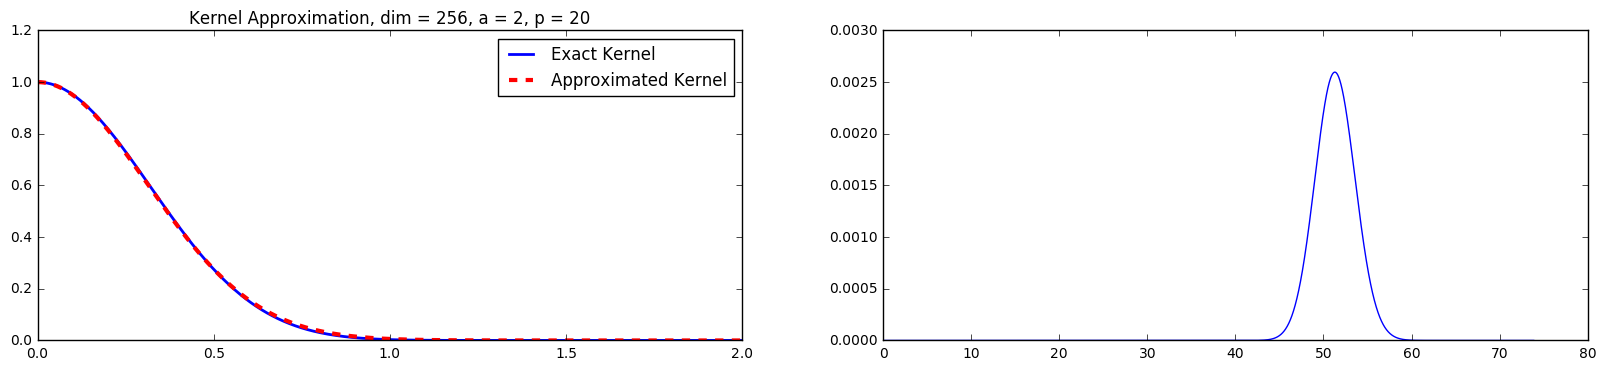

In [145]:
z = np.linspace(0,2,10*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,B))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,10*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

In [138]:
DIM, EPS, GRID_SIZE = 1000, 1e-20, 500
A,B, N = 2,2, 10

def polynomial_kernel_scalar(z, a = A, degree = B):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
Kapp.fit()

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.


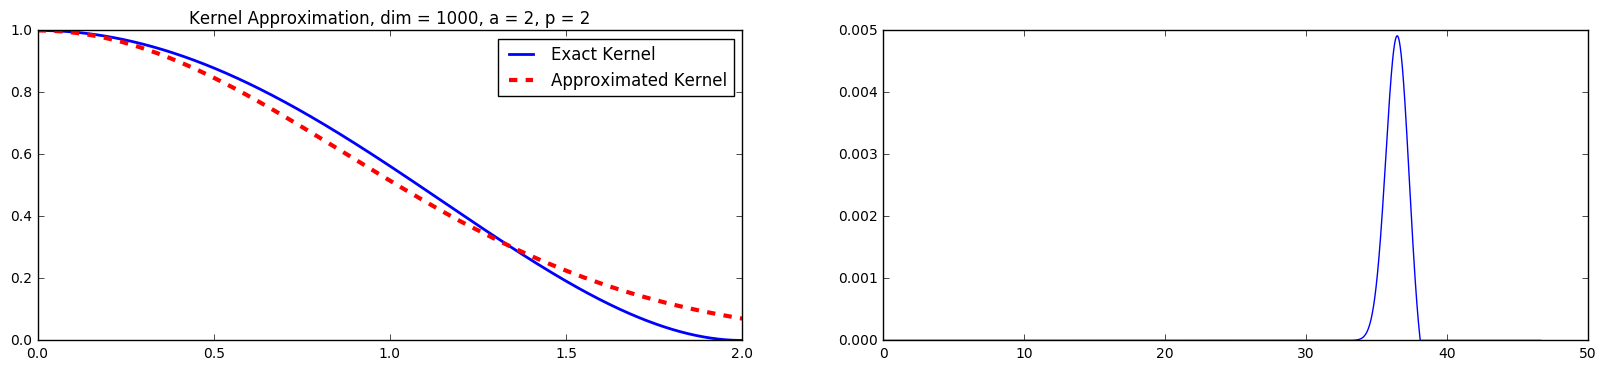

In [139]:
z = np.linspace(0,2,10*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,B))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,10*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

# In the Next Notebook: 
- Implementation of the second Python class SRFF that performs Random Fourier Features sampling and the low dimentional embedding Z(X). 

 <a href="SRF-II.ipynb"> Go to the next notebook </a>